In [376]:
lab_enc = True
ohe = True
new_features = True
hp_tune = False
balance_train = False
add_tags = True
add_names = True
tfidf_title = False
oversample = False

TRAIN_SIZE = 0.8
TEST_SIZE = 0.2

In [228]:
tags = []
names = []

## Column Names and Description

In [33]:
"""
Columns
The following columns are available on the training set:

accepts_mercadopago Whether the item accepts Mercado Pago
available_quantity The available stock quantity at that moment
avg_asp_item_bday Average selling price of this item over the last days
avg_asp_item_domain Average price of items of the domain this item belongs to
avg_asp_item_sel Average price of seller sales
avg_gmv_item_bday average revenue generated by the item per day
avg_gmv_item_domain_30days Average revenue generated by the items of this domain on the last month
avg_gmv_item_sel Average revenue of items of this seller
avg_gmv_seller_bday Average revenue this seller makes by day
avg_orders_item_bday Average number of orders this item has by day
avg_orders_seller_bday Average orders the seller has by day
avg_qty_orders_item_domain_30days Average number of orders a random item of this domain made on the last month
avg_qty_orders_item_sel_30days Average number of orders an item of this seller makes on the last 30 days
avg_si_item_bday Average units sold this item has by day
avg_si_item_sel_30day Average units sold of an item of this seller on the past month
avg_visits_item Average visits this item had
benefit Ignore, should be dropped
boosted Whether the item was boosted
buy_server_timestamp Timestamp of the purchase
category_id Category of this item
conversion Target variable, it is True if this print has an attributed order
cus_cust_id Buyer id
cus_cust_id_sel Seller id
date Print date
deal_print_id Unique id for the print
decimals Ignore, will be dropped
domain_id Domain id for the item
etl_version Ignore, should be dropped
free_shipping Whether the item has free shipping
fulfillment Whether the item is fulfilled by MeLi
full_name Category full name
health Item health
is_pdp Whether the click landed on a PDP
product_id Product_id of the item
item_id ID of the item, useful for debugging
listing_type_id Whether the item is gold or not
logistic_type Logistic type for the item
main_picture URL for the main item picture
offset On which page the item was rendered
original_price Price from which the discount was done
platform Which platform the user is using
price Item price
print_position Position on the page
print_server_timestamp Timestamp for the print
qty_items_dom Number of items this domain has
qty_items_sel Number of items the seller has
rn Leftover from the ETL, Discard
ROW_ID Row of the submission file
site_id Site ID
sold_quantity Number of items sold at the moment of the print
tags Tags the item had at the moment of the print
title Item title
total_asp_item_domain_30days Average selling price of the items of the domain
total_asp_item_sel_30days Average selling price of all the items the seller sold on the last 30 days
total_gmv_domain_30days Total revenue the domain made on the last 30 days
total_gmv_domain_bday total_gmv_domain_30days / 30
total_gmv_item_30days Total revenue made by the item on the lasts 30 days
total_gmv_seller Total revenue made by the seller on the last month
total_items_domain Number of items on the domain
total_items_seller Number of items the seller has
total_orders_domain_30days Total orders on the domain
total_orders_item_30days Total orders the Item had on the last 30 days
total_orders_sel_30days Total orders for the seller
total_si_domain_30days Total units sold of this domain
total_si_item_30days Total units sold of this item
total_si_sel_30days Same for the seller
total_visits_domain Total visits on this domain
total_visits_item Total visits this item had
total_visits_seller Total visits for this seller
uid session id
user_id user id
warranty Whether the item had warranty
"""

'\nColumns\nThe following columns are available on the training set:\n\naccepts_mercadopago Whether the item accepts Mercado Pago\navailable_quantity The available stock quantity at that moment\navg_asp_item_bday Average selling price of this item over the last days\navg_asp_item_domain Average price of items of the domain this item belongs to\navg_asp_item_sel Average price of seller sales\navg_gmv_item_bday average revenue generated by the item per day\navg_gmv_item_domain_30days Average revenue generated by the items of this domain on the last month\navg_gmv_item_sel Average revenue of items of this seller\navg_gmv_seller_bday Average revenue this seller makes by day\navg_orders_item_bday Average number of orders this item has by day\navg_orders_seller_bday Average orders the seller has by day\navg_qty_orders_item_domain_30days Average number of orders a random item of this domain made on the last month\navg_qty_orders_item_sel_30days Average number of orders an item of this seller 

## Librerias

In [229]:
from IPython.display import display, Markdown

import pandas as pd

import gc

import os

from sklearn.impute import SimpleImputer

from sklearn.preprocessing import LabelEncoder, PolynomialFeatures, StandardScaler, OneHotEncoder

from sklearn.pipeline import make_pipeline

from sklearn.tree import DecisionTreeClassifier, plot_tree

from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier, VotingClassifier, HistGradientBoostingClassifier, StackingClassifier, BaggingClassifier

from sklearn.model_selection import RandomizedSearchCV, train_test_split, KFold, cross_val_score

from sklearn.metrics import roc_auc_score,  roc_curve, auc, confusion_matrix

from sklearn.feature_extraction.text import TfidfVectorizer

from hyperopt import hp, fmin, tpe, Trials, STATUS_OK, space_eval

import xgboost as xgb

import numpy as np

import matplotlib.pyplot as plt

import itertools

from tqdm import tqdm

import re

from datetime import datetime

from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from gensim.models import Word2Vec
import pacmap

import nltk

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /Users/nacho/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/nacho/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Funciones

In [230]:
def plot_roc_curves(models, model_names, X_test, y_test, ax=None):

    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 10))

    for i in range(len(models)):
        fpr, tpr, thresholds = roc_curve(y_test, models[i].predict_proba(X_test)[:, models[i].classes_ == 1])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=1, label=model_names[i] + ' (area = %0.5f)' % roc_auc)

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

    plt.xlim([-0.05, 1.0])

    plt.ylim([0.0, 1.05])

    plt.xlabel('False Positive Rate')

    plt.ylabel('True Positive Rate')

    plt.title('Receiver operating characteristic example')

    # Show grid
    plt.grid(True)

    plt.legend(loc="lower right")

    plt.show()

In [231]:
def notify(title, text):
    os.system("""
              osascript -e 'display notification "{}" with title "{}"'
              """.format(text, title))

## Load Comp Data

In [232]:
comp_data = pd.read_csv("data/competition_data.csv")

In [233]:
comp_data.head()

,accepts_mercadopago,available_quantity,avg_gmv_item_domain_30days,avg_gmv_item_sel,avg_gmv_seller_bday,avg_qty_orders_item_domain_30days,avg_qty_orders_item_sel_30days,avg_si_item_sel_30day,benefit,boosted,...,total_si_domain_30days,total_si_item_30days,total_si_sel_30days,total_visits_domain,total_visits_item,total_visits_seller,uid,user_id,warranty,ROW_ID
0,True,59,938.031376,2153.933091,135195.200333,3.430563,12.407860,13.691450,0.001,False,...,56717.0,17.0,25781.0,7993972,543,854813,cb5bfac7-229a-4e3e-96dd-80b2ad3972c1,NaN,Garantía de fábrica: 12 meses,NaN
1,True,37,159.826531,240.325973,19338.230000,3.142739,4.429577,4.511599,0.001,False,...,81455.0,5.0,10891.0,7821316,1789,1422288,b0f9aa19-00d5-4afd-aa77-45be7c849562,NaN,NaN,NaN
2,True,9,67.635391,86.066296,154.919333,2.633771,2.592593,2.722222,0.001,False,...,16792.0,8.0,147.0,1303909,1473,17801,fd59890a-f2c2-4282-b2ee-c68f25e20697,151157147.0,NaN,NaN
3,True,12,92.085756,332.848400,554.747333,3.280069,12.620000,12.840000,0.001,False,...,1988.0,14.0,642.0,139419,7473,44336,72340acf-2a1c-4214-a604-132e0cb56939,NaN,Garantía de fábrica: 90 días,NaN
4,True,5,156.905222,955.997475,3154.791667,2.737876,3.666667,4.363636,0.001,False,...,8707.0,32.0,432.0,209373,416,46206,84da1314-814c-4d4f-be23-3de9ea1da4b6,NaN,Garantía del vendedor: 90 días,NaN


In [234]:
comp_data.describe()

,available_quantity,avg_gmv_item_domain_30days,avg_gmv_item_sel,avg_gmv_seller_bday,avg_qty_orders_item_domain_30days,avg_qty_orders_item_sel_30days,avg_si_item_sel_30day,benefit,conversion,health,...,total_orders_item_30days,total_orders_sel_30days,total_si_domain_30days,total_si_item_30days,total_si_sel_30days,total_visits_domain,total_visits_item,total_visits_seller,user_id,ROW_ID
count,199972.000000,195607.000000,195607.000000,195607.000000,195607.000000,195607.000000,195607.000000,199971.000000,180761.000000,199972.000000,...,195607.000000,195607.000000,195607.000000,195607.000000,195607.000000,1.999720e+05,199972.000000,1.999720e+05,1.783750e+05,19211.000000
mean,2142.683766,333.141264,1160.099822,10815.338962,4.385187,13.542561,18.286236,0.000976,0.092631,0.809401,...,65.176297,3941.158614,29197.693135,88.487667,5238.731257,2.170257e+06,5571.603790,2.542803e+05,2.246094e+08,9605.000000
std,11326.386712,492.836951,4284.246365,26377.753704,2.768258,25.645743,33.648431,0.000154,0.289915,0.146368,...,129.610777,5145.727129,49694.994203,220.606860,6809.183739,3.545316e+06,12108.897095,3.458552e+05,1.474232e+08,5545.882346
min,0.000000,4.909057,4.773333,0.660000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,...,1.000000,2.000000,4.000000,1.000000,2.000000,3.160000e+02,1.000000,1.100000e+01,1.610000e+02,0.000000
25%,19.000000,86.729688,143.184865,793.281667,2.876796,4.188679,4.916896,0.001000,0.000000,0.770000,...,6.000000,718.000000,3938.000000,7.000000,943.000000,1.899680e+05,407.000000,4.804600e+04,1.053200e+08,4802.500000
50%,67.000000,169.234106,262.266733,2733.067000,3.639912,6.768293,8.875000,0.001000,0.000000,0.810000,...,20.000000,2102.000000,11660.000000,24.000000,2713.000000,5.613990e+05,1496.000000,1.263900e+05,1.976426e+08,9605.000000
75%,371.000000,319.281502,675.989333,9217.855667,5.066384,13.403873,18.558559,0.001000,0.000000,0.900000,...,63.000000,5017.000000,38725.000000,80.000000,6455.000000,2.007145e+06,5248.000000,2.817150e+05,3.202613e+08,14407.500000
max,99999.000000,3778.257881,57282.961233,244988.442667,38.148629,258.363636,465.500000,0.001000,1.000000,1.000000,...,1853.000000,36492.000000,505258.000000,8269.000000,56189.000000,1.591114e+07,195413.000000,2.938795e+06,1.000014e+09,19210.000000


In [235]:
display(
    Markdown(
        "\n".join(
            [
                #"- **{}** ({}) \n\n {}".format(col, dtype, comp_data[col].value_counts()) for col, dtype in
                #"- **{}** ({})".format(col, dtype) for col, dtype in
                #zip(comp_data.columns, comp_data.dtypes)
                "- **{}**".format(col) for col in comp_data.columns
            ]
        )
    )
)

- **accepts_mercadopago**
- **available_quantity**
- **avg_gmv_item_domain_30days**
- **avg_gmv_item_sel**
- **avg_gmv_seller_bday**
- **avg_qty_orders_item_domain_30days**
- **avg_qty_orders_item_sel_30days**
- **avg_si_item_sel_30day**
- **benefit**
- **boosted**
- **category_id**
- **conversion**
- **date**
- **deal_print_id**
- **domain_id**
- **etl_version**
- **free_shipping**
- **fulfillment**
- **full_name**
- **health**
- **is_pdp**
- **product_id**
- **item_id**
- **listing_type_id**
- **logistic_type**
- **main_picture**
- **offset**
- **original_price**
- **platform**
- **price**
- **print_position**
- **print_server_timestamp**
- **qty_items_dom**
- **qty_items_sel**
- **site_id**
- **sold_quantity**
- **tags**
- **title**
- **total_asp_item_domain_30days**
- **total_asp_item_sel_30days**
- **total_gmv_domain_bday**
- **total_gmv_item_30days**
- **total_items_domain**
- **total_items_seller**
- **total_orders_domain_30days**
- **total_orders_item_30days**
- **total_orders_sel_30days**
- **total_si_domain_30days**
- **total_si_item_30days**
- **total_si_sel_30days**
- **total_visits_domain**
- **total_visits_item**
- **total_visits_seller**
- **uid**
- **user_id**
- **warranty**
- **ROW_ID**

## Data Cleaning

In [236]:
#comp_data = pd.read_csv("data/competition_data.csv")
comp_data = comp_data.drop(
        columns=[
            "accepts_mercadopago", # Todos tienen mercadopago
            "boosted", # Ninguno
            "avg_qty_orders_item_domain_30days",
            "avg_qty_orders_item_sel_30days",
            "avg_si_item_sel_30day",
            #"date",
            "deal_print_id",
            "etl_version",
            #"full_name",
            "main_picture",
            "print_server_timestamp",
            #"title",
            "uid",
            #"user_id",
            "avg_gmv_item_domain_30days",
            #"avg_gmv_item_sel",
            "avg_gmv_seller_bday",
            #"qty_items_dom",
            #"category_id",
            #"domain_id",
            #"product_id",
            #"listing_type_id",
            # "logistic_type",
            "site_id",
            #"tags",
            "total_asp_item_sel_30days", 
            "total_gmv_domain_bday", 
            #"total_items_domain", 
            "total_items_seller", 
            "total_orders_domain_30days", 
            "total_orders_item_30days", 
            "total_orders_sel_30days", 
            "total_si_sel_30days", 
            #"total_visits_domain", 
            #"total_visits_item", 
            #"total_visits_seller",
            "total_asp_item_domain_30days",
            "total_gmv_item_30days",
            "total_si_domain_30days",
            "total_si_item_30days",
            #"warranty",
            # "offset",
        ]
    )

In [237]:
comp_data["warranty"] = comp_data["warranty"].str.lower()
comp_data["warranty"] = comp_data["warranty"].str.replace("á", "a")
comp_data["warranty"] = comp_data["warranty"].str.replace("í", "i")

In [238]:
comp_data["warranty_saler"] = comp_data["warranty"].str.contains("vendedor").astype(float)
comp_data["warranty_factory"] = comp_data["warranty"].str.contains("fabrica").astype(float)
comp_data["warranty_no"] = comp_data["warranty"].str.contains("sin garantia").astype(float)
comp_data["warranty_missing"] = (~comp_data["warranty"].isna()).astype(float)
comp_data["warranty_days"] = comp_data["warranty"].str.extract("(\d+) dias").astype(float)

In [239]:
def warranty_duration(warranty):
    if pd.isna(warranty):
        return np.nan
    elif "sin garantia" in warranty:
        return 0
    else:
        if "dias" in warranty:
            matches = re.findall("(\d+) dias", warranty)
            if len(matches) == 0:
                return np.nan
            else:
                return int(matches[0])
        elif "meses" in warranty:
            matches = re.findall("(\d+) meses", warranty)
            if len(matches) == 0:
                return np.nan
            else:
                return int(matches[0]) * 30    
        elif "años" in warranty:
            matches = re.findall("(\d+) años", warranty)
            if len(matches) == 0:
                return np.nan
            else:
                return int(matches[0]) * 365
        else:
            return np.nan

#list(map(lambda x: warranty_duration(x), comp_data["warranty"]))

comp_data["warranty_days"] = comp_data["warranty"].apply(warranty_duration)
comp_data["warranty_days_missing"] = (~comp_data["warranty_days"].isna()).astype(float)

In [240]:
comp_data[["warranty", "warranty_missing", "warranty_days", "warranty_days_missing", "warranty_saler", "warranty_factory", "warranty_no"]]

,warranty,warranty_missing,warranty_days,warranty_days_missing,warranty_saler,warranty_factory,warranty_no
0,garantia de fabrica: 12 meses,1.0,360.0,1.0,0.0,1.0,0.0
1,NaN,0.0,NaN,0.0,NaN,NaN,NaN
2,NaN,0.0,NaN,0.0,NaN,NaN,NaN
3,garantia de fabrica: 90 dias,1.0,90.0,1.0,0.0,1.0,0.0
4,garantia del vendedor: 90 dias,1.0,90.0,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...
199967,sin garantia,1.0,0.0,1.0,0.0,0.0,1.0
199968,garantia del vendedor: 20 dias,1.0,20.0,1.0,1.0,0.0,0.0
199969,sin garantia,1.0,0.0,1.0,0.0,0.0,1.0
199970,NaN,0.0,NaN,0.0,NaN,NaN,NaN


In [241]:
# comp_data["warranty"].value_counts().head(50)

In [242]:
comp_data.drop(columns=["warranty"], inplace=True)

In [243]:
display(
    Markdown(
        "\n".join(
            [
                #"- **{}** ({}) \n\n {}".format(col, dtype, comp_data[col].value_counts()) for col, dtype in
                #"- **{}** ({})".format(col, dtype) for col, dtype in
                #zip(comp_data.columns, comp_data.dtypes)
                "- **{}**".format(col) for col in comp_data.columns
            ]
        )
    )
)

- **available_quantity**
- **avg_gmv_item_sel**
- **benefit**
- **category_id**
- **conversion**
- **date**
- **domain_id**
- **free_shipping**
- **fulfillment**
- **full_name**
- **health**
- **is_pdp**
- **product_id**
- **item_id**
- **listing_type_id**
- **logistic_type**
- **offset**
- **original_price**
- **platform**
- **price**
- **print_position**
- **qty_items_dom**
- **qty_items_sel**
- **sold_quantity**
- **tags**
- **title**
- **total_items_domain**
- **total_visits_domain**
- **total_visits_item**
- **total_visits_seller**
- **user_id**
- **ROW_ID**
- **warranty_saler**
- **warranty_factory**
- **warranty_no**
- **warranty_missing**
- **warranty_days**
- **warranty_days_missing**

In [244]:
if add_tags:
    if len(tags) == 0:
        #tags = comp_data["tags"].str.replace("[", "").str.replace("]", "").str.split(", ").apply(pd.Series).stack().value_counts()
        # more efficient
        tags = comp_data["tags"].str.replace("[", "").str.replace("]", "").str.split(", ").explode().value_counts()

    for tag in tags.index:
        comp_data["tag_" + tag] = comp_data["tags"].str.contains(tag).astype(int)

    comp_data["tags_count"] = comp_data["tags"].str.replace("[", "").str.replace("]", "").str.split(", ").apply(len)

    comp_data = comp_data.drop("tags", axis=1)

/var/folders/5j/7b3w3dw95qdcll87vxc3yn300000gn/T/ipykernel_68815/55024603.py:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  tags = comp_data["tags"].str.replace("[", "").str.replace("]", "").str.split(", ").explode().value_counts()
/var/folders/5j/7b3w3dw95qdcll87vxc3yn300000gn/T/ipykernel_68815/55024603.py:10: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  comp_data["tags_count"] = comp_data["tags"].str.replace("[", "").str.replace("]", "").str.split(", ").apply(len)


In [245]:
if add_names:
    if len(names) == 0:
        names = comp_data["full_name"].str.split(" -> ").explode().value_counts().head(20).index

    for name in names:
        comp_data["name_" + name] = comp_data["full_name"].str.contains(name).astype(int)

    comp_data = comp_data.drop("full_name", axis=1)


In [246]:
comp_data["date"] = pd.to_datetime(comp_data["date"])
comp_data["day"] = comp_data["date"].dt.day
comp_data["month"] = comp_data["date"].dt.month
#comp_data["hour"] = comp_data["date"].dt.hour
# comp_data["year"] = comp_data["date"].dt.year
comp_data["dayofweek"] = comp_data["date"].dt.dayofweek
comp_data["weekofmonth"] = comp_data["date"].dt.day // 7
# comp_data["weekofyear"] = comp_data["date"].dt.isocalendar().week
comp_data["quarter"] = comp_data["date"].dt.quarter
comp_data["hour"] = comp_data["date"].dt.hour
# comp_data["minute"] = comp_data["date"].dt.minute

# Morning, afternoon, night
comp_data["morning"] = (comp_data["hour"] >= 6) & (comp_data["hour"] < 12)
comp_data["morning"] = comp_data["morning"].astype(float)
comp_data["afternoon"] = (comp_data["hour"] >= 12) & (comp_data["hour"] < 18)
comp_data["afternoon"] = comp_data["afternoon"].astype(float)
comp_data["night"] = (comp_data["hour"] >= 18) & (comp_data["hour"] < 24)
comp_data["night"] = comp_data["night"].astype(float)

In [247]:
comp_data[['date', 'day', 'month', 'dayofweek', 'weekofmonth', 'quarter', 'hour', 'morning', 'afternoon', 'night']]

,date,day,month,dayofweek,weekofmonth,quarter,hour,morning,afternoon,night
0,2020-03-06,6,3,4,0,1,0,0.0,0.0,0.0
1,2020-04-01,1,4,2,0,2,0,0.0,0.0,0.0
2,2020-04-08,8,4,2,1,2,0,0.0,0.0,0.0
3,2020-04-25,25,4,5,3,2,0,0.0,0.0,0.0
4,2020-03-10,10,3,1,1,1,0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
199967,2020-04-12,12,4,6,1,2,0,0.0,0.0,0.0
199968,2020-04-03,3,4,4,0,2,0,0.0,0.0,0.0
199969,2020-04-01,1,4,2,0,2,0,0.0,0.0,0.0
199970,2020-04-08,8,4,2,1,2,0,0.0,0.0,0.0


In [248]:
comp_data["date"].min(), comp_data["date"].max()

(Timestamp('2020-03-01 00:00:00'), Timestamp('2020-04-25 00:00:00'))

In [249]:
comp_data = comp_data.drop(columns=["date"])

### Parse boolean columns

In [250]:
# comp_data["boosted"] = comp_data["boosted"].astype(int)
comp_data["free_shipping"] = comp_data["free_shipping"].astype(int)
comp_data["fulfillment"] = comp_data["fulfillment"].astype(int)

comp_data["imp_user_id"] = comp_data["user_id"].isna().astype(int)
comp_data["user_id"].fillna(-1, inplace=True)
comp_data["user_id"] = comp_data["user_id"].astype(int)

comp_data["listing_type_id"] = comp_data["listing_type_id"].apply(lambda x: 0 if x == "gold_special" else 1)

In [251]:
""" 
comp_data["imp_is_pdp"] = comp_data["is_pdp"].isna().astype(int)
comp_data["is_pdp"].fillna(0, inplace=True)
comp_data["is_pdp"] = comp_data["is_pdp"].astype(int)
 """

' \ncomp_data["imp_is_pdp"] = comp_data["is_pdp"].isna().astype(int)\ncomp_data["is_pdp"].fillna(0, inplace=True)\ncomp_data["is_pdp"] = comp_data["is_pdp"].astype(int)\n '

In [252]:
comp_data["is_pdp"].isna().sum()

90184

In [253]:
comp_data["imp_is_pdp"] = comp_data["is_pdp"].isna().astype(int)

In [254]:
comp_data["is_pdp"].isna().sum()

90184

In [255]:
comp_data["is_pdp"][~comp_data["is_pdp"].isna()].value_counts()

False    109136
True        652
Name: is_pdp, dtype: int64

In [256]:
comp_data["imp_is_pdp"].value_counts()

0    109788
1     90184
Name: imp_is_pdp, dtype: int64

In [257]:
#comp_data["is_pdp"].fillna(-1, inplace=True)
# Small Logistic Regression to fill is_pdp
X_is_pdp_train, X_is_pdp_test, y_is_pdp_train, y_is_pdp_test = train_test_split(
    comp_data[~comp_data["is_pdp"].isna()].drop(columns=["is_pdp"]).select_dtypes(include='number'), 
    comp_data[~comp_data["is_pdp"].isna()][["is_pdp"]].astype(bool),
    test_size=0.2, 
    random_state=42
)

model = make_pipeline(
    xgb.XGBClassifier(
        n_jobs=-1,
    )
)

model.fit(X_is_pdp_train, y_is_pdp_train)

# Keep same ammount of False and True for Test

y_is_pdp_test = y_is_pdp_test[y_is_pdp_test["is_pdp"] == 1].append(y_is_pdp_test[y_is_pdp_test["is_pdp"] == 0].sample(n=y_is_pdp_test[y_is_pdp_test["is_pdp"] == 1].shape[0], random_state=42))
X_is_pdp_test = X_is_pdp_test.loc[y_is_pdp_test.index]

roc_auc_score(y_is_pdp_test, model.predict_proba(X_is_pdp_test)[:,1])

0.9995793522023917

In [220]:
comp_data[comp_data["is_pdp"].isna()].drop(columns=["is_pdp"]).select_dtypes(include='number')

,available_quantity,avg_gmv_item_sel,benefit,conversion,free_shipping,fulfillment,health,product_id,listing_type_id,offset,...,month,dayofweek,weekofmonth,quarter,hour,morning,afternoon,night,imp_user_id,imp_is_pdp
6,82,495.326667,0.001,0.0,0,0,0.83,14012093.0,0,0,...,4,5,3,2,0,0.0,0.0,0.0,0,1
8,7,214.277733,0.001,0.0,0,1,0.77,NaN,0,144,...,4,5,3,2,0,0.0,0.0,0.0,0,1
10,566,3088.639634,0.000,0.0,1,0,0.88,NaN,1,0,...,4,2,1,2,0,0.0,0.0,0.0,1,1
14,101,214.441442,0.001,0.0,1,0,0.70,NaN,0,96,...,4,5,1,2,0,0.0,0.0,0.0,0,1
16,44,200.589045,0.001,0.0,1,0,0.81,NaN,0,48,...,4,0,2,2,0,0.0,0.0,0.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199961,77,103.061703,0.001,NaN,1,0,0.80,NaN,0,240,...,4,6,0,2,0,0.0,0.0,0.0,0,1
199962,51,12876.690840,0.001,NaN,1,1,0.90,14663092.0,1,576,...,4,6,1,2,0,0.0,0.0,0.0,0,1
199964,20,NaN,0.001,NaN,0,1,0.87,14041143.0,0,384,...,4,2,1,2,0,0.0,0.0,0.0,0,1
199969,20,327.451321,0.001,NaN,0,1,0.66,NaN,0,48,...,4,2,0,2,0,0.0,0.0,0.0,0,1


In [258]:
pred_is_pdp = model.predict_proba(comp_data[comp_data["is_pdp"].isna()].drop(columns=["is_pdp"]).select_dtypes(include='number'))[:,1]
comp_data.loc[comp_data["is_pdp"].isna(), "is_pdp"] = pred_is_pdp

In [259]:
comp_data["is_pdp"] = comp_data["is_pdp"].astype(int)

### Encoding

In [260]:
if ohe:
    # One Hot Encoding

    cats =  comp_data["category_id"].value_counts().index
    top_cats = cats[:10]
    
    prod_ids = comp_data["product_id"].value_counts().index
    top_prod_ids = prod_ids[:10]

    """ comp_data = pd.get_dummies(comp_data,
                            columns = [
                                #"platform",
                                #"logistic_type",
                                "product_id",
                                "category_id",
                                # "domain_id"
                                ],
                            sparse = True,    # Devolver una matriz rala.
                            dummy_na = False, # No agregar columna para NaNs.
                            dtype = int       # XGBoost no trabaja con 'object'; necesitamos que sean numéricos.
                        ) """
    
    # drop category_id columns that are not in top_cats
    """ for cat in cats:
        if cat not in top_cats:
            comp_data = comp_data.drop(columns=["category_id_" + str(cat)])
    
    for prod_id in prod_ids:
        if prod_id not in top_prod_ids:
            comp_data = comp_data.drop(columns=["product_id_" + str(prod_id)]) """
    
    for tc in top_cats:
        comp_data["category_id_" + str(tc)] = (comp_data["category_id"] == tc).astype(int)
    
    for tpi in top_prod_ids:
        comp_data["product_id_" + str(tpi)] = (comp_data["product_id"] == tpi).astype(int)

if lab_enc:
    # Label Encoding
    
    comp_data["platform"] = LabelEncoder().fit_transform(comp_data["platform"]).astype(int)
    #comp_data["category_id"] = LabelEncoder().fit_transform(comp_data["category_id"]).astype(int)
    comp_data["domain_id"] = LabelEncoder().fit_transform(comp_data["domain_id"]).astype(int)
    comp_data["logistic_type"] = LabelEncoder().fit_transform(comp_data["logistic_type"]).astype(int)
    if not ohe:
        comp_data["product_id"] = LabelEncoder().fit_transform(comp_data["product_id"]).astype(int)


In [261]:
comp_data

,available_quantity,avg_gmv_item_sel,benefit,category_id,conversion,domain_id,free_shipping,fulfillment,health,is_pdp,...,product_id_15190794.0,product_id_15315495.0,product_id_15582422.0,product_id_8730036.0,product_id_14542731.0,product_id_8886378.0,product_id_15243601.0,product_id_14786767.0,product_id_13513981.0,product_id_14630500.0
0,59,2153.933091,0.001,MLA1055,0.0,299,1,0,0.00,0,...,0,0,0,0,0,0,0,0,0,0
1,37,240.325973,0.001,MLA3724,0.0,1380,1,0,0.81,0,...,0,0,0,0,0,0,0,0,0,0
2,9,86.066296,0.001,MLA109282,0.0,1147,0,1,0.80,0,...,0,0,0,0,0,0,0,0,0,0
3,12,332.848400,0.001,MLA38493,0.0,1578,1,1,1.00,0,...,0,0,0,0,0,0,0,0,0,0
4,5,955.997475,0.001,MLA1694,0.0,1274,0,0,0.81,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199967,63,313.907255,0.001,MLA412631,NaN,498,0,1,0.77,0,...,0,0,0,0,0,0,0,0,0,0
199968,23256,137.436786,0.001,MLA393757,NaN,561,0,0,0.80,0,...,0,0,0,0,0,0,0,0,0,0
199969,20,327.451321,0.001,MLA3697,NaN,776,0,1,0.66,0,...,0,0,0,0,0,0,0,0,0,0
199970,45,102.352949,0.001,MLA3422,NaN,7,0,0,0.88,0,...,0,0,0,0,0,0,0,0,0,0


### New columns

In [262]:
if new_features:
    comp_data["price_diff"] = comp_data["price"] - comp_data["original_price"]
    comp_data["price_diff"] = comp_data["price_diff"].apply(lambda x: abs(x)).astype(int)

    comp_data["discount"] = (comp_data["original_price"] - comp_data["price"]) / comp_data["original_price"]
    comp_data["discount"] = comp_data["discount"].apply(lambda x: 1 if x == np.inf else x)

    comp_data["price_ratio"] = comp_data["price"] / comp_data["original_price"]
    comp_data["price_ratio"] = comp_data["price_ratio"].apply(lambda x: 1 if x == np.inf else x)

    comp_data["is_discount"] = comp_data["discount"].apply(lambda x: 1 if x > 0 else 0)

    comp_data["title_length"] = comp_data["title"].str.len()
    comp_data["title_word_count"] = comp_data["title"].str.split(" ").apply(len)

    comp_data["title_length_word_count"] = comp_data["title_length"] / comp_data["title_word_count"]
    comp_data["title_length_word_count"] = comp_data["title_length_word_count"].apply(lambda x: 1 if x == np.inf else x)

    comp_data["domain_dominance"] = comp_data["sold_quantity"] / comp_data["qty_items_dom"]

    comp_data["is_pdp_tvi"] = comp_data["is_pdp"] / comp_data["total_visits_item"]
    comp_data["is_pdp_tvi"] = comp_data["is_pdp_tvi"].apply(lambda x: 1 if x == np.inf else x)

    comp_data["is_pdp_tvs"] = comp_data["is_pdp"] / comp_data["total_visits_seller"]
    comp_data["is_pdp_tvs"] = comp_data["is_pdp_tvs"].apply(lambda x: 1 if x == np.inf else x)

    comp_data["is_pdp_tvd"] = comp_data["is_pdp"] / comp_data["total_visits_domain"]
    comp_data["is_pdp_tvd"] = comp_data["is_pdp_tvd"].apply(lambda x: 1 if x == np.inf else x)


In [263]:
# comp_data = comp_data.dropna(subset=["avg_gmv_item_sel"])

# Fil nas for ["avg_gmv_item_sel", "qty_items_dom", "qty_items_sel", "domain_dominance"]

comp_data["nan_imputed"] = comp_data["avg_gmv_item_sel"].isna().astype(int)

comp_data["avg_gmv_item_sel"] = comp_data["avg_gmv_item_sel"].fillna(comp_data["avg_gmv_item_sel"].median())
comp_data["qty_items_dom"] = comp_data["qty_items_dom"].fillna(comp_data["qty_items_dom"].median())
comp_data["qty_items_sel"] = comp_data["qty_items_sel"].fillna(comp_data["qty_items_sel"].median())
comp_data["domain_dominance"] = comp_data["domain_dominance"].fillna(comp_data["domain_dominance"].median())

### Polynomial Features

In [264]:
# PolynomialFeatures custom

poly_attrs = ["print_position", "offset", "discount", "price", "health", "original_price"]

for x in poly_attrs:
    comp_data[x + "2"] = comp_data[x] ** 2

for (x, y) in itertools.combinations(poly_attrs, 2):
    comp_data[x + "2 + " + y + "2"] = comp_data[x] ** 2 + comp_data[y] ** 2


In [265]:
comp_data

,available_quantity,avg_gmv_item_sel,benefit,category_id,conversion,domain_id,free_shipping,fulfillment,health,is_pdp,...,offset2 + discount2,offset2 + price2,offset2 + health2,offset2 + original_price2,discount2 + price2,discount2 + health2,discount2 + original_price2,price2 + health2,price2 + original_price2,health2 + original_price2
0,59,2153.933091,0.001,MLA1055,0.0,299,1,0,0.00,0,...,0.090006,440958001,0.0000,899940001,4.409580e+08,0.090006,8.999400e+08,4.409580e+08,1340898002,8.999400e+08
1,37,240.325973,0.001,MLA3724,0.0,1380,1,0,0.81,0,...,82944.162517,16074945,82944.6561,44972944,1.599200e+07,0.818617,4.489000e+07,1.599200e+07,60882001,4.489000e+07
2,9,86.066296,0.001,MLA109282,0.0,1147,0,1,0.80,0,...,2304.010000,1800585,2304.6400,2222404,1.798281e+06,0.650000,2.220100e+06,1.798282e+06,4018381,2.220101e+06
3,12,332.848400,0.001,MLA38493,0.0,1578,1,1,1.00,0,...,0.019703,9042049,1.0000,12236004,9.042049e+06,1.019703,1.223600e+07,9.042050e+06,21278053,1.223600e+07
4,5,955.997475,0.001,MLA1694,0.0,1274,0,0,0.81,0,...,0.040128,996004,0.6561,1557504,9.960040e+05,0.696228,1.557504e+06,9.960047e+05,2553508,1.557505e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199967,63,313.907255,0.001,MLA412631,NaN,498,0,1,0.77,0,...,20736.010000,1966761,20736.5929,2423236,1.946025e+06,0.602900,2.402500e+06,1.946026e+06,4348525,2.402501e+06
199968,23256,137.436786,0.001,MLA393757,NaN,561,0,0,0.80,0,...,0.008343,332929,0.6400,403225,3.329290e+05,0.648343,4.032250e+05,3.329296e+05,736154,4.032256e+05
199969,20,327.451321,0.001,MLA3697,NaN,776,0,1,0.66,0,...,2304.014938,757465,2304.4356,982404,7.551610e+05,0.450538,9.801000e+05,7.551614e+05,1735261,9.801004e+05
199970,45,102.352949,0.001,MLA3422,NaN,7,0,0,0.88,0,...,20736.090105,1467945,20736.7744,2975697,1.447209e+06,0.864505,2.954961e+06,1.447210e+06,4402170,2.954962e+06


## Exploratory

In [113]:
display(
    Markdown(
        "\n".join(
            [
                #"- **{}** ({}) \n\n {}".format(col, dtype, comp_data[col].value_counts()) for col, dtype in
                #"- **{}** ({})".format(col, dtype) for col, dtype in
                #zip(comp_data.columns, comp_data.dtypes)
                "- **{}**".format(col) for col in comp_data.columns
            ]
        )
    )
)

- **available_quantity**
- **avg_gmv_item_sel**
- **benefit**
- **category_id**
- **conversion**
- **domain_id**
- **free_shipping**
- **fulfillment**
- **health**
- **is_pdp**
- **product_id**
- **item_id**
- **listing_type_id**
- **logistic_type**
- **offset**
- **original_price**
- **platform**
- **price**
- **print_position**
- **qty_items_dom**
- **qty_items_sel**
- **sold_quantity**
- **title**
- **total_items_domain**
- **total_visits_domain**
- **total_visits_item**
- **total_visits_seller**
- **user_id**
- **ROW_ID**
- **warranty_days**
- **warranty_saler**
- **warranty_factory**
- **warranty_no**
- **warranty_missing**
- **tag_immediate_payment**
- **tag_good_quality_picture**
- **tag_brand_verified**
- **tag_good_quality_thumbnail**
- **tag_cart_eligible**
- **tag_loyalty_discount_eligible**
- **tag_today_promotion**
- **tag_extended_warranty_eligible**
- **tag_ahora-12**
- **tag_deal_of_the_day**
- **tag_dragged_bids_and_visits**
- **tag_incomplete_technical_specs**
- **tag_catalog_listing_eligible**
- **tag_lightning_deal**
- **tag_poor_quality_picture**
- **tag_poor_quality_thumbnail**
- **tag_supermarket_eligible**
- **tag_under_infractions**
- **tags_count**
- **name_Hogar, Muebles y Jardín**
- **name_Ropa y Accesorios**
- **name_Zapatillas**
- **name_Herramientas y Construcción**
- **name_Deportes y Fitness**
- **name_Calzado**
- **name_Belleza y Cuidado Personal**
- **name_Electrónica, Audio y Video**
- **name_Celulares y Teléfonos**
- **name_Herramientas**
- **name_Celulares y Smartphones**
- **name_Electrodomésticos y Aires Ac.**
- **name_Juegos y Juguetes**
- **name_Bazar y Cocina**
- **name_Audio**
- **name_Bebés**
- **name_Salud y Equipamiento Médico**
- **name_Computación**
- **name_Iluminación para el Hogar**
- **name_Otros**
- **day**
- **month**
- **dayofweek**
- **weekofmonth**
- **quarter**
- **hour**
- **morning**
- **afternoon**
- **night**
- **imp_user_id**
- **imp_is_pdp**
- **price_diff**
- **discount**
- **price_ratio**
- **is_discount**
- **title_length**
- **title_word_count**
- **title_length_word_count**
- **domain_dominance**
- **is_pdp_tvi**
- **is_pdp_tvs**
- **is_pdp_tvd**
- **nan_imputed**
- **print_position2**
- **offset2**
- **discount2**
- **price2**
- **health2**
- **original_price2**
- **print_position2 + offset2**
- **print_position2 + discount2**
- **print_position2 + price2**
- **print_position2 + health2**
- **print_position2 + original_price2**
- **offset2 + discount2**
- **offset2 + price2**
- **offset2 + health2**
- **offset2 + original_price2**
- **discount2 + price2**
- **discount2 + health2**
- **discount2 + original_price2**
- **price2 + health2**
- **price2 + original_price2**
- **health2 + original_price2**

In [625]:
# Check this columns for variance
# accepts_mercadopago
# available_quantity
# avg_gmv_item_domain_30days
# avg_gmv_item_sel
# avg_gmv_seller_bday
# avg_qty_orders_item_domain_30days
# avg_qty_orders_item_sel_30days
# avg_si_item_sel_30day
# benefit
# boosted
# category_id
# conversion
# date
# deal_print_id
# domain_id
# etl_version
# free_shipping
# fulfillment
# full_name
# health
# is_pdp
# product_id
# item_id
# listing_type_id
# logistic_type
# main_picture
# offset
# original_price
# platform
# price
# print_position
# print_server_timestamp
# qty_items_dom
# qty_items_sel
# old_quantity
# tags
# title
# total_asp_item_domain_30days
# total_asp_item_sel_30days
# total_gmv_domain_bday
# total_gmv_item_30days
# total_items_domain
# total_items_seller
# total_orders_domain_30days
# total_orders_item_30days
# total_orders_sel_30days
# total_si_domain_30days
# total_si_item_30days
# total_si_sel_30days
# total_visits_domain
# total_visits_item
# total_visits_seller
# uid
# user_id
# warranty

# for col in comp_data.columns:
#     print()
#     print(col)
#     print(comp_data[col].value_counts().head(5))

In [626]:
# comp_data.groupby("user_id")["conversion"].sum()
# comp_data[comp_data["conversion"] == True]["user_id"].value_counts()

In [627]:
# Balance conversion
# comp_data = comp_data.drop(comp_data[comp_data["conversion"] == False].sample(frac=.5).index)

In [628]:
# comp_data["conversion"].value_counts()

### Plots

In [114]:
# sub_data = comp_data.sample(50000)

sub_data = comp_data[comp_data["conversion"] == True].sample(10000).append(comp_data[comp_data["conversion"] == False].sample(10000))

In [123]:
poly_attrs

['print_position', 'offset', 'discount', 'price', 'health', 'original_price']

In [129]:
cov_ignore = poly_attrs + [x + "2 + " + y + "2" for (x, y) in itertools.combinations(poly_attrs, 2)] + [poly+"2" for poly in poly_attrs]

covs = sub_data.drop(columns=cov_ignore).cov()

for i in range(len(covs)):
    covs.iloc[i,i] = 0

max_covs = covs.unstack().sort_values(ascending=False).drop_duplicates().head(10)

max_covs_cols = max_covs.index.map(lambda x: x[0]).unique()

In [126]:
import seaborn as sns

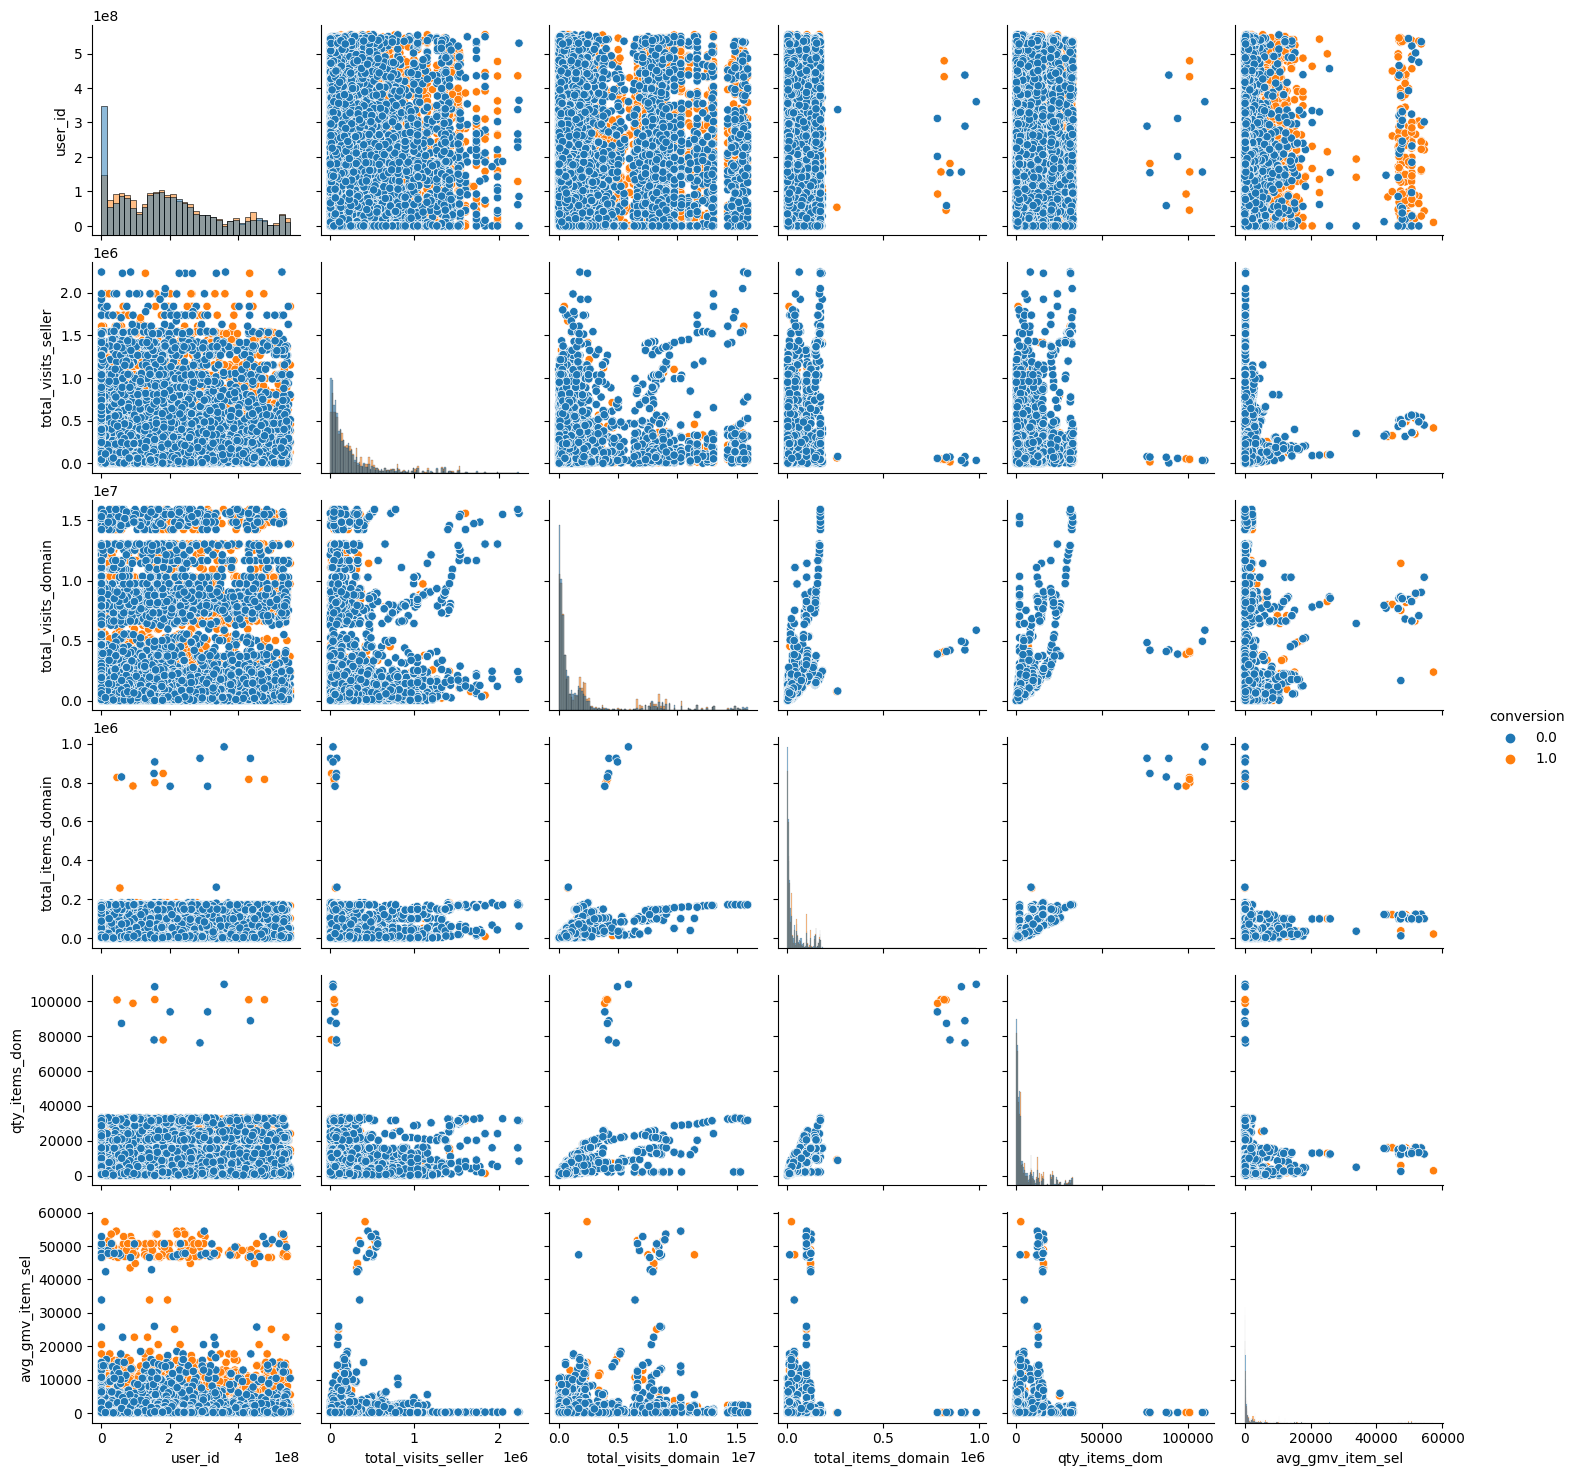

In [132]:
sns.pairplot(sub_data[list(max_covs_cols) + ["conversion"]], hue="conversion", dropna=True, diag_kind="hist")

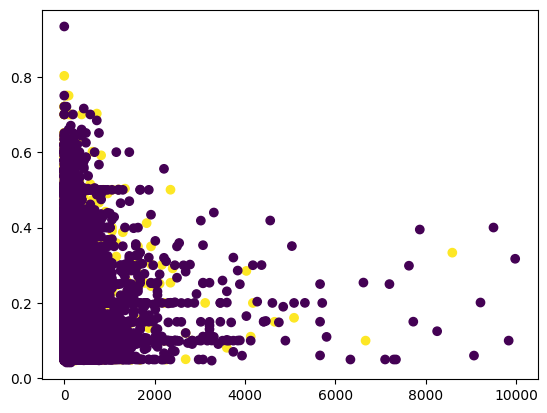

In [630]:
# Plot 'offset' vs 'category_id' . Dot color depends on 'conversion'
plt.scatter(sub_data["offset"], sub_data["discount"], c=sub_data["conversion"])

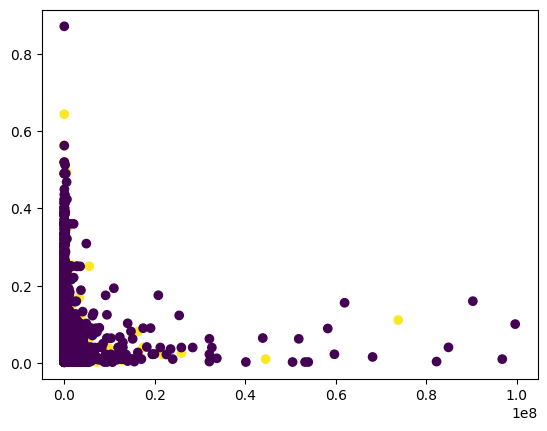

In [631]:
plt.scatter(sub_data["offset2"], sub_data["discount2"], c=sub_data["conversion"])

Text(0, 0.5, 'original_price')

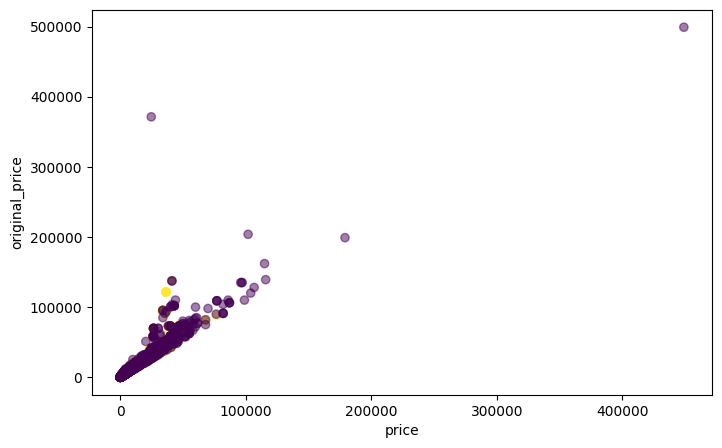

In [632]:
fig, ax = plt.subplots(figsize=(8, 5))

ax.scatter(sub_data["price"], sub_data["original_price"], c=sub_data["conversion"], alpha=0.5)

ax.set_xlabel("price")
ax.set_ylabel("original_price")

Text(0, 0.5, 'offset')

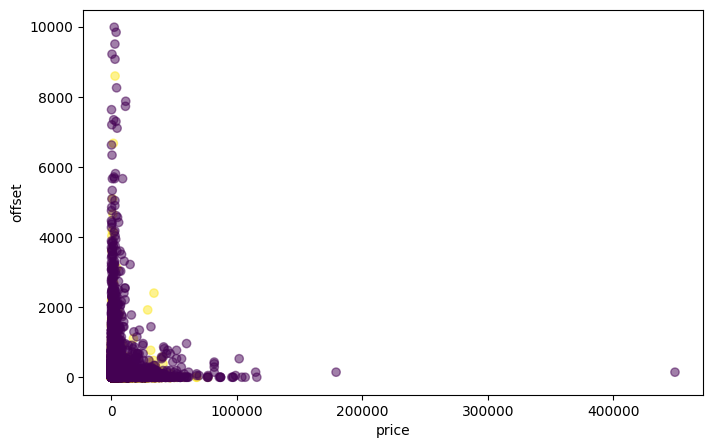

In [633]:
fig, ax = plt.subplots(figsize=(8, 5))

ax.scatter(sub_data["price"], sub_data["offset"], c=sub_data["conversion"], alpha=0.5)

ax.set_xlabel("price")
ax.set_ylabel("offset")

Text(0, 0.5, 'offset2')

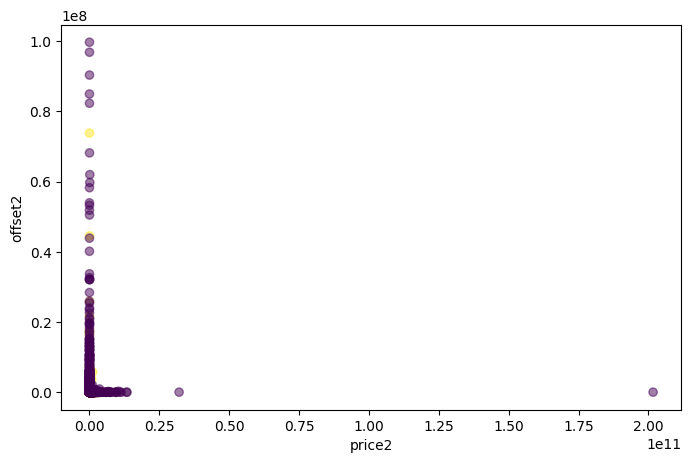

In [634]:
fig, ax = plt.subplots(figsize=(8, 5))

ax.scatter(sub_data["price2"], sub_data["offset2"], c=sub_data["conversion"], alpha=0.5)

ax.set_xlabel("price2")
ax.set_ylabel("offset2")

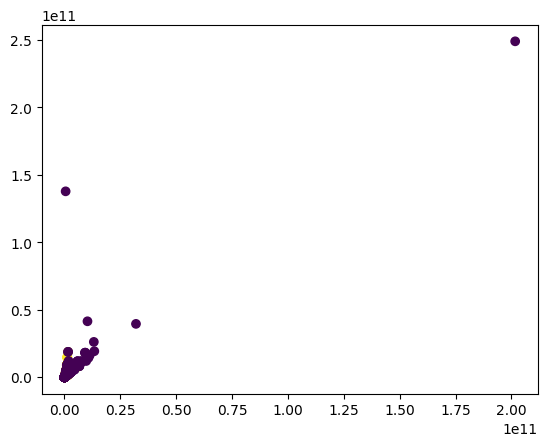

In [635]:
plt.scatter(sub_data["price2"], sub_data["original_price2"], c=sub_data["conversion"])

Text(0.5, 0, 'is_pdp')

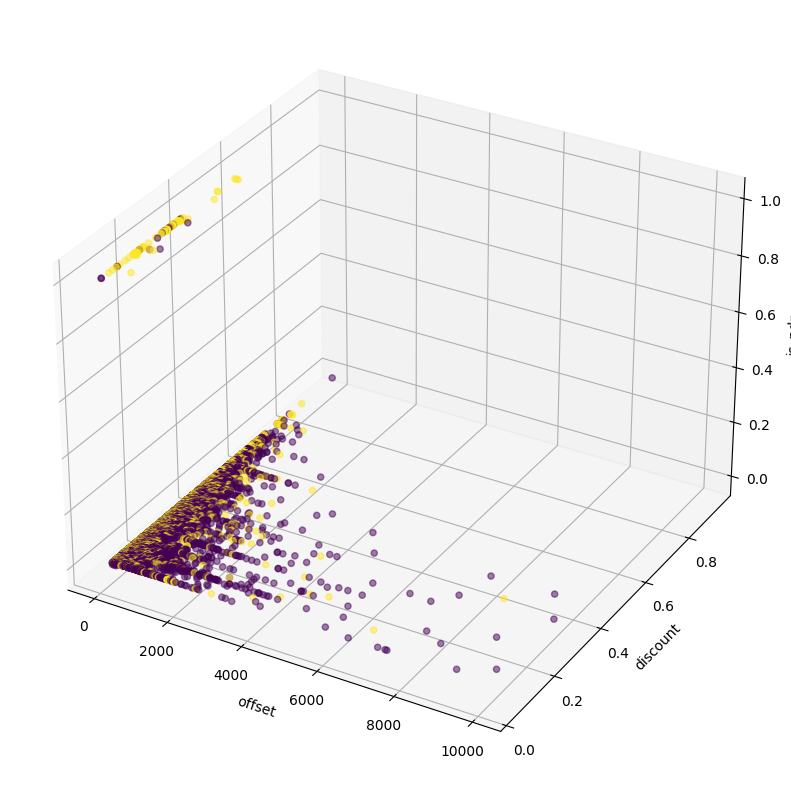

In [636]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(
    sub_data["offset"],
    sub_data["discount"],
    sub_data["is_pdp"],
    c=sub_data["conversion"],
    # cmap="coolwarm",
    alpha=.5
)

ax.set_xlabel("offset")
ax.set_ylabel("discount")
ax.set_zlabel("is_pdp")


Text(0.5, 0, 'price_diff')

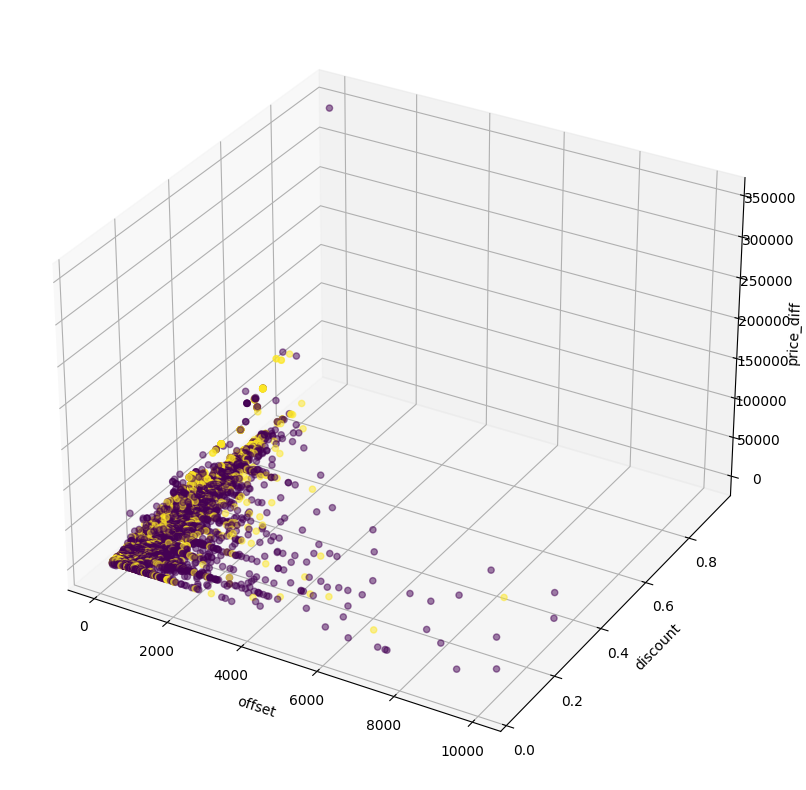

In [637]:
# Plot 'offset', 'discount', 'category_id' in 3D. Dot color depends on 'conversion'

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(
    sub_data["offset"],
    sub_data["discount"],
    sub_data["price_diff"],
    c=sub_data["conversion"],
    # cmap="coolwarm",
    alpha=.5
)

ax.set_xlabel("offset")
ax.set_ylabel("discount")
ax.set_zlabel("price_diff")


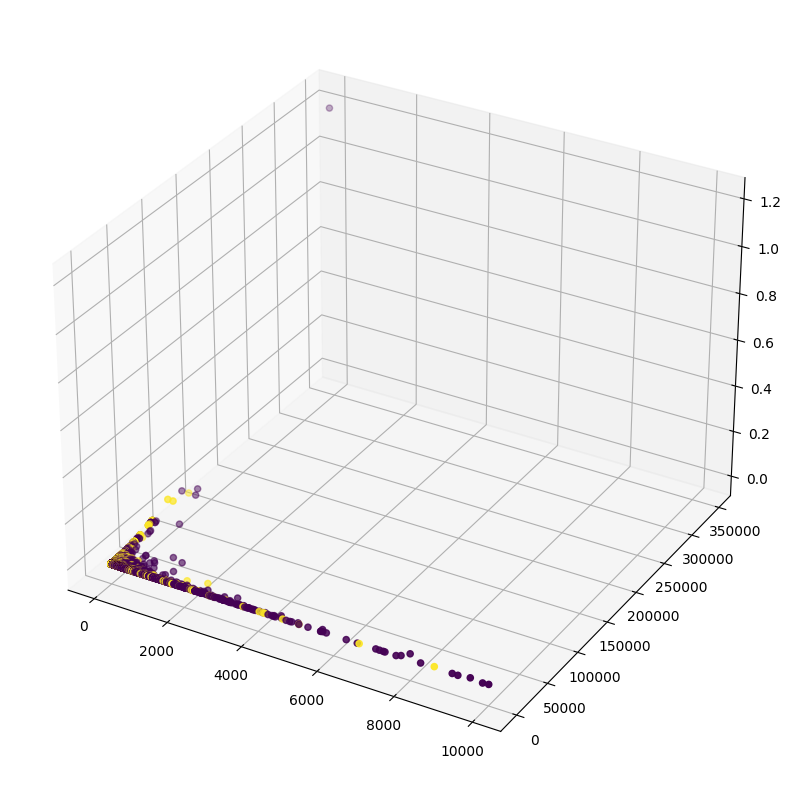

In [638]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
# ax = fig.add_subplot(111)
ax.scatter(
    sub_data["offset"],
    sub_data["price_diff"],
    sub_data["offset"] ** 2 + sub_data["price_diff"]**2,
    c=sub_data["conversion"],
)

plt.show()

In [639]:
# # Plot hist boosted
# plot_data = comp_data.groupby("is_pdp")["conversion"].sum()
# plot_data


In [640]:
# Plot hour vs conversion
#comp_data.groupby("dayofweek")["conversion"].mean().plot()

## Word2Vec

In [266]:
comp_data["tokenized_title"] = comp_data["title"].apply(sent_tokenize)
comp_data["tokenized_title"] = comp_data["tokenized_title"].apply(lambda x: [word_tokenize(y) for y in x])
comp_data["tokenized_title"] = comp_data["tokenized_title"].apply(lambda x: [[y2 for y2 in y1 if re.compile("[A-Za-z]").search(y2[0])] for y1 in x])
comp_data["tokenized_title"] = comp_data["tokenized_title"].apply(lambda x: [[y2.lower() for y2 in y1] for y1 in x])

In [267]:
# Word2Vec with NLTk
RETRAIN_W2C = False
if RETRAIN_W2C:
        
    stop_words = set(stopwords.words('spanish'))

    w2v_model = Word2Vec(vector_size=300,
                                    window=3,
                                    min_count=5,
                                    negative=15,
                                    sample=0.01,
                                    workers=8,
                                    sg=1)
                                                                        
    w2v_model.build_vocab([e2 for e1 in comp_data["tokenized_title"].values for e2 in e1],
                    progress_per=10000)

    w2v_model.train([e2 for e1 in comp_data["tokenized_title"].values for e2 in e1],
                total_examples=w2v_model.corpus_count,
                epochs=30, report_delay=1)

    w2v_model.save("title_w2c.model")

else:
    w2v_model = Word2Vec.load("title_w2c.model")

In [ ]:
# Obtención de embeddings de títulos utilizando el modelo Word2Vec
comp_data["title_embs"] = comp_data["tokenized_title"].apply(lambda x: np.mean(
    [   
        np.zeros(w2v_model.wv.vector_size) if e2 not in w2v_model.wv 
        else w2v_model.wv.get_vector(e2) if len(e2) > 0 
        else np.zeros(w2v_model.wv.vector_size) 
        for e1 in x for e2 in e1
    ],
    axis=0)
)

In [36]:
np.array(comp_data["title_embs"].tolist()).shape

(199972, 300)

In [ ]:
comp_data["tokenized_title"] = comp_data["tokenized_title"].apply(lambda x: x[0])

In [137]:
comp_data["tokenized_title"]

0         [motorola, one, action, gb, denim, blue, gb, ram]
1                  [zapatillas, hovr, sonic, under, armour]
2         [pantalon, mujer, vestir, elastizado, tiro, al...
3         [trencity, pista, n°3, kit, turbo, elevación, ...
4              [memoria, ram, ddr2, samsung, intel, y, amd]
                                ...                        
199967    [frasco, dispenser, vidrio, c/relieve, c/sopor...
199968    [electro, estimulador, abdominal, reductor, fi...
199969    [auricular, bluetooth, vincha, micro, sd, radi...
199970               [transformers, generations, dreadwind]
199971    [pack, x, boxer, de, niño, sin, costura, dufou...
Name: tokenized_title, Length: 199972, dtype: object

In [ ]:
comp_data[["embeddings_" + str(i) for i in range(w2v_model.wv.vector_size)]] = np.array(comp_data["title_embs"].tolist())

/Users/nacho/opt/anaconda3/envs/coding/lib/python3.8/site-packages/pandas/core/frame.py:3678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[col] = igetitem(value, i)


In [139]:
comp_data[["embeddings_" + str(i) for i in range(w2v_model.wv.vector_size)]]

,embeddings_0,embeddings_1,embeddings_2,embeddings_3,embeddings_4,embeddings_5,embeddings_6,embeddings_7,embeddings_8,embeddings_9,...,embeddings_290,embeddings_291,embeddings_292,embeddings_293,embeddings_294,embeddings_295,embeddings_296,embeddings_297,embeddings_298,embeddings_299
0,0.407256,0.346109,0.034703,0.195872,0.105712,-0.096924,-0.086645,0.763543,-0.264425,-0.250102,...,0.048355,0.202031,0.284862,0.279447,-0.106692,0.484675,-0.141178,0.164191,-0.153946,0.044015
1,0.042679,0.285040,-0.085519,0.054269,-0.436977,0.009165,-0.043031,0.918024,0.396576,-0.262409,...,-0.329382,0.585860,-0.075787,0.415753,0.589815,0.373095,0.112062,-0.196132,0.075105,-0.205592
2,-0.140189,0.221102,0.334784,0.663381,-0.193465,0.098738,0.163559,0.354226,0.279351,0.449124,...,-0.069502,-0.015078,0.180559,0.182157,0.445096,0.668092,0.144087,-0.223072,0.156411,0.269213
3,0.270412,0.124530,-0.116732,-0.203255,-0.323604,-0.048130,-0.159898,0.539274,0.206988,-0.055276,...,-0.274872,0.565224,0.358737,0.405583,0.602786,0.236667,0.317710,-0.108944,0.071862,-0.418499
4,0.177160,0.292062,-0.015661,0.067940,-0.138912,-0.243836,-0.062292,0.367834,-0.398819,-0.350346,...,-0.174848,0.222140,0.151210,0.078478,0.247092,0.196130,-0.105131,-0.139780,0.086428,-0.121699
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199967,-0.060557,0.086833,-0.055899,0.432190,-0.289145,-0.332855,0.415789,0.651786,-0.046805,-0.163709,...,-0.339807,0.105469,0.433681,0.120821,0.088977,0.233058,0.041193,-0.284257,0.019409,-0.319288
199968,-0.022782,-0.132960,-0.091529,0.444677,-0.515899,-0.142040,0.105987,0.580728,-0.488041,0.226574,...,-0.239526,0.395446,0.367903,0.003991,0.608837,0.322964,-0.000260,-0.403646,0.192786,-0.169928
199969,-0.120085,0.523469,0.212257,0.103961,-0.145219,-0.450245,0.103901,0.687452,-0.217462,-0.370850,...,-0.104306,0.210506,0.166247,0.054639,0.178691,0.089791,0.084518,-0.169389,-0.356164,-0.158580
199970,-0.079217,0.150441,0.177942,-0.019753,-0.168739,0.015797,-0.058106,0.147978,0.160441,0.052064,...,0.177821,0.189710,0.576359,0.444357,-0.023808,0.005769,0.015664,-0.245347,0.143789,-0.290579


In [140]:
# Reduce dimensionality of embeddings

dims = 30

pacmap_model = pacmap.PaCMAP(
    n_components = dims,
    verbose = True,
)


In [42]:
embs = pacmap_model.fit_transform(comp_data[["embeddings_" + str(i) for i in range(w2v_model.wv.vector_size)]].values)

embs.shape

Applied PCA, the dimensionality becomes 100
PaCMAP(n_neighbors=10, n_MN=5, n_FP=20, distance=euclidean, lr=1.0, n_iters=450, apply_pca=True, opt_method='adam', verbose=True, intermediate=False, seed=None)
Finding pairs
Found nearest neighbor
Calculated sigma
Found scaled dist
Pairs sampled successfully.
((1999720, 2), (999860, 2), (3999440, 2))
Initial Loss: 2471032.0
Iteration:   10, Loss: 2806961.250000
Iteration:   20, Loss: 1648746.000000
Iteration:   30, Loss: 1426670.250000
Iteration:   40, Loss: 1282504.500000
Iteration:   50, Loss: 1182756.875000
Iteration:   60, Loss: 1097099.000000
Iteration:   70, Loss: 1009329.375000
Iteration:   80, Loss: 907065.812500
Iteration:   90, Loss: 773920.875000
Iteration:  100, Loss: 551025.625000
Iteration:  110, Loss: 851476.062500
Iteration:  120, Loss: 725377.875000
Iteration:  130, Loss: 680788.437500
Iteration:  140, Loss: 663092.625000
Iteration:  150, Loss: 657698.125000
Iteration:  160, Loss: 656582.250000
Iteration:  170, Loss: 657310.

(199972, 30)

In [269]:
comp_data[["pacmap_" + str(i) for i in range(dims)]] = embs

In [ ]:
# Drop comp_data[["embeddings_" + str(i) for i in range(w2v_model.wv.vector_size)]]

comp_data = comp_data.drop(columns=["embeddings_" + str(i) for i in range(w2v_model.wv.vector_size)])


In [272]:
comp_data = comp_data.drop(columns=["title_embs", "tokenized_title"])

In [138]:
# # Poly_pacmap

# poly_attrs = ["pacmap_" + str(i) for i in range(dims)]

# for x in poly_attrs:
#     comp_data[x + "^2"] = comp_data[x] ** 2

# for (x, y) in itertools.combinations(poly_attrs, 2):
#     comp_data[x + "2 + " + y + "2"] = comp_data[x] ** 2 + comp_data[y] ** 2

In [101]:
# comp_data = comp_data.drop(columns=["tokenized_title"])

In [160]:
# Delete pca_cols
# pca_cols = comp_data.columns[comp_data.columns.str.contains("pacmap")]
# comp_data = comp_data.drop(columns=pca_cols)

In [273]:
list(comp_data.columns)

['available_quantity',
 'avg_gmv_item_sel',
 'benefit',
 'category_id',
 'conversion',
 'domain_id',
 'free_shipping',
 'fulfillment',
 'health',
 'is_pdp',
 'product_id',
 'item_id',
 'listing_type_id',
 'logistic_type',
 'offset',
 'original_price',
 'platform',
 'price',
 'print_position',
 'qty_items_dom',
 'qty_items_sel',
 'sold_quantity',
 'title',
 'total_items_domain',
 'total_visits_domain',
 'total_visits_item',
 'total_visits_seller',
 'user_id',
 'ROW_ID',
 'warranty_saler',
 'warranty_factory',
 'warranty_no',
 'warranty_missing',
 'warranty_days',
 'warranty_days_missing',
 'tag_immediate_payment',
 'tag_good_quality_picture',
 'tag_brand_verified',
 'tag_good_quality_thumbnail',
 'tag_cart_eligible',
 'tag_loyalty_discount_eligible',
 'tag_today_promotion',
 'tag_extended_warranty_eligible',
 'tag_ahora-12',
 'tag_deal_of_the_day',
 'tag_dragged_bids_and_visits',
 'tag_incomplete_technical_specs',
 'tag_catalog_listing_eligible',
 'tag_lightning_deal',
 'tag_poor_qualit

In [648]:
# tfidf = TfidfVectorizer(max_features=1000, lowercase=True, analyzer='word',ngram_range=(1,1), sublinear_tf=True)

# if tfidf_title:
#     tfidf_title = pd.DataFrame(tfidf.fit_transform(comp_data["title"]).toarray(), columns=tfidf.get_feature_names_out())
#     comp_data = pd.concat([comp_data, tfidf_title], axis=1)
#     comp_data = comp_data.drop("title", axis=1)

## Splits

### Split Comp Data -> Full | Eval

In [377]:
full_data = comp_data[comp_data["ROW_ID"].isna()]
eval_data = comp_data[comp_data["ROW_ID"].notna()]
# del comp_data
gc.collect()

232

### Train Test Split

In [358]:
eval_count = eval_data.shape[0]
eval_count

19211

In [379]:
test_count_equals_eval_count = False

In [380]:
# Shuffle
full_data = full_data.sample(frac=1, random_state=19092140).reset_index(drop=True)

if test_count_equals_eval_count:
    test_data = full_data.sample(eval_count, random_state=42)
    train_data = full_data.drop(test_data.index)
else:
    train_data, test_data = train_test_split(full_data, test_size=TEST_SIZE, train_size=TRAIN_SIZE, random_state=42)


train_data.shape[0], test_data.shape[0], eval_data.shape[0]

(144608, 36153, 19211)

In [381]:
# Oversample train_data

if oversample:
    true_conversion = train_data[train_data["conversion"] == True]
    train_data = train_data.append(true_conversion).append(true_conversion)


In [370]:
train_data.shape[0]

191556

In [656]:
# train_vect = tfidf.fit_transform(train_data["title"])

In [657]:
# if tfidf_title:
#     train_df = pd.DataFrame(train_vect.toarray())
#     train_data[tfidf.get_feature_names_out()] = train_df

#     test_vect = tfidf.transform(test_data["title"])
#     test_df = pd.DataFrame(test_vect.toarray())
#     test_data[tfidf.get_feature_names_out()] = test_df

#     eval_vect = tfidf.transform(eval_data["title"])
#     eval_df = pd.DataFrame(eval_vect.toarray())
#     eval_data[tfidf.get_feature_names_out()] = eval_df

### Balancing

In [346]:
count_converts_test = test_data[test_data["conversion"] == True].shape[0]
count_not_converts_test = test_data[test_data["conversion"] == False].shape[0]
ratio = count_converts_test / count_not_converts_test

# From test_data, keep ratio of count_not_converts_test entries

not_converts = test_data[test_data["conversion"] == False].sample(frac=ratio)

new_test_data = pd.concat([test_data[test_data["conversion"] == True], not_converts])
new_test_data["conversion"].value_counts()

1.0    1741
0.0    1741
Name: conversion, dtype: int64

In [337]:
# Balance Train Data by conversion

len(train_data[train_data["conversion"] == False])

146562

In [382]:
# if NaN in conversion, drop those rows
train_data = train_data.dropna(subset=["conversion"])
test_data = test_data.dropna(subset=["conversion"])

In [349]:
if balance_train:

    count_converts_train = len(train_data[train_data["conversion"] == True])
    count_not_converts_train = len(train_data[train_data["conversion"] == False])

    ratio = count_converts_train / count_not_converts_train

    # From train_data, keep ratio of count_not_converts_train entries

    not_converts = train_data[train_data["conversion"] == False].sample(frac=ratio)

    new_train_data = pd.concat([train_data[train_data["conversion"] == True], not_converts])

    train_data = new_train_data

In [383]:
train_data

,available_quantity,avg_gmv_item_sel,benefit,category_id,conversion,domain_id,free_shipping,fulfillment,health,is_pdp,...,pacmap_20,pacmap_21,pacmap_22,pacmap_23,pacmap_24,pacmap_25,pacmap_26,pacmap_27,pacmap_28,pacmap_29
119995,4,267.235556,0.001,MLA1387,0.0,99,0,1,0.88,0,...,-0.050314,1.775878,1.720939,0.672152,-2.250934,-0.157544,-0.246444,0.187764,1.130999,-0.305208
178425,22,341.896026,0.001,MLA30768,0.0,312,1,0,0.80,0,...,2.420587,1.294380,1.751232,-0.885159,-2.197089,-1.230065,-1.170722,0.615996,2.857962,-0.192856
65203,1117,212.401667,0.001,MLA431275,0.0,798,0,0,1.00,0,...,-1.020156,1.932571,0.162232,3.102659,5.048106,-2.760331,8.669392,2.633308,-6.396140,-1.807003
62035,968,290.453635,0.001,MLA413229,0.0,916,0,0,0.87,0,...,2.102591,2.520541,0.922309,-0.883516,-1.237273,-1.266971,-1.260451,0.820754,2.370512,-0.075130
68736,17905,656.905205,0.001,MLA3697,0.0,776,0,0,0.81,0,...,-0.415431,1.654742,-0.968483,4.014912,0.255978,-1.682019,0.265359,0.970169,5.429779,1.434361
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119879,45,190.115978,0.001,MLA1586,0.0,1651,0,0,0.63,0,...,-5.677804,-3.949645,-4.112866,1.754162,-0.172851,1.030960,-1.803238,0.848732,0.048135,0.210211
103694,53,101.773000,0.001,MLA403698,0.0,378,0,0,1.00,0,...,-3.656246,2.715449,0.920892,-1.476625,-0.314228,-1.869269,1.595532,0.025360,-0.150385,0.159080
131932,24,224.505281,0.001,MLA433673,1.0,814,0,1,0.88,0,...,-1.884812,2.762221,-2.174352,-0.399847,-0.823054,-4.505190,4.632109,-2.812131,-2.210166,-1.271297
146867,9,1794.036854,0.001,MLA8618,0.0,1395,0,0,0.60,0,...,1.542764,1.750782,1.127370,-1.462249,-1.833973,-0.784102,-1.750668,0.355280,1.508968,-1.098531


In [351]:
train_data["conversion"].value_counts()

1.0    15003
0.0    15003
Name: conversion, dtype: int64

In [663]:
# ! Oversample, repeats into Validation
# train_data = train_data.append(train_data[train_data["conversion"] == True].sample(frac=1, replace=True))
# train_data = train_data.append(train_data[train_data["conversion"] == True].sample(frac=1, replace=True))
# train_data["conversion"].value_counts()

###  Split X | y

In [384]:
y_train = train_data["conversion"]
X_train = train_data.drop(columns=["conversion", "ROW_ID"])
X_train = X_train.select_dtypes(include='number')

y_test = test_data["conversion"]
X_test = test_data.drop(columns=["conversion", "ROW_ID"])
X_test = X_test.select_dtypes(include='number')

del train_data
del test_data

gc.collect()

0

In [365]:
X_train

,available_quantity,avg_gmv_item_sel,benefit,domain_id,free_shipping,fulfillment,health,is_pdp,product_id,listing_type_id,...,pacmap_20,pacmap_21,pacmap_22,pacmap_23,pacmap_24,pacmap_25,pacmap_26,pacmap_27,pacmap_28,pacmap_29
0,1825,238.673558,0.001,730,0,0,0.90,0,NaN,0,...,2.279983,1.045447,1.800566,-0.814517,-1.311645,-0.919673,-0.358683,0.507653,2.231141,-0.746926
1,219,2724.514074,0.001,1512,1,1,0.88,0,NaN,0,...,1.309742,1.334822,4.928528,3.315150,0.229959,-0.420497,2.371810,-1.992172,-0.365592,-0.033171
2,19,196.694854,0.001,1461,1,0,0.80,0,NaN,0,...,2.328327,2.226956,0.343034,-1.312407,-1.722272,-1.118991,-1.594527,0.768317,1.820038,-0.687130
3,172,167.790992,0.001,742,0,0,0.80,0,9751198.0,0,...,1.322946,-4.514786,-1.384465,0.049832,-3.076139,0.810975,-1.696138,1.651865,-0.613655,-3.193295
4,15,221.004478,0.001,1698,1,0,0.81,0,8955499.0,0,...,-3.504261,0.587698,-0.623991,3.140168,0.726577,6.013417,3.766329,-0.162060,-0.749793,-0.552453
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180650,40,1450.138491,0.000,1418,1,0,0.90,0,15576099.0,1,...,2.997934,-0.232255,-0.056923,4.917864,-6.054542,4.755309,-2.398122,-0.723968,-2.259874,-0.612433
180658,9635,613.422568,0.001,776,1,0,1.00,0,NaN,1,...,1.269672,-0.721307,-0.661230,-3.626488,-0.239942,1.297491,3.402363,-2.284786,-1.346419,1.711210
180672,57,2165.432500,0.001,1377,1,1,0.90,0,14786767.0,0,...,2.033576,-0.735421,-0.619551,6.094503,-0.814356,2.558650,0.973617,-0.366196,1.266469,2.140842
180736,3848,3237.485918,0.001,1395,1,1,1.00,0,NaN,1,...,0.206707,-2.364513,0.956585,-1.961312,2.467798,3.008757,-2.473979,-4.885755,-0.175406,-0.784898


### Validation Split

In [385]:
X_train_sub, X_val, y_train_sub, y_val = train_test_split(X_train, y_train, test_size=0.25, train_size=0.75, random_state=42)

## Submission File

In [284]:
def create_submission_file(model, feature_cols=[], filename="submission.csv"):
    global comp_data
    global eval_data
    
    if len(feature_cols) == 0:
        feature_cols = model.get_booster().feature_names

    #feature_cols = xgb4_model.get_booster().feature_names
    #model = final_classifier

    eval_data = comp_data[comp_data["ROW_ID"].notna()]
    # del comp_data

    # Predict on the evaluation set
    eval_data = eval_data.drop(columns=["conversion"])
    eval_data = eval_data.select_dtypes(include='number')
    y_preds = model.predict_proba(eval_data[feature_cols])[:, model.classes_ == 1].squeeze()

    # Make the submission file
    submission_df = pd.DataFrame({"ROW_ID": eval_data["ROW_ID"], "conversion": y_preds})
    submission_df["ROW_ID"] = submission_df["ROW_ID"].astype(int)
    submission_df.to_csv(filename, index=False)

## Models

### XGBoost

In [354]:
random_state = 12345

In [ ]:
full_data = comp_data[comp_data["ROW_ID"].isna()]
train_data, test_data = train_test_split(full_data, test_size=0.25, train_size=0.75, random_state=42)

y_train = train_data["conversion"]
X_train = train_data.drop(columns=["conversion", "ROW_ID"])
X_train_tokenized_title = X_train["tokenized_title"]
X_train = X_train.select_dtypes(include='number')
X_train["tokenized_title"] = X_train_tokenized_title

y_test = test_data["conversion"]
X_test = test_data.drop(columns=["conversion", "ROW_ID"])
X_test_tokenized_title = X_test["tokenized_title"]
X_test = X_test.select_dtypes(include='number')
X_test["tokenized_title"] = X_test_tokenized_title

del train_data
del test_data
del full_data
gc.collect()

tfidf = TfidfVectorizer(tokenizer=lambda x: x, token_pattern=None, lowercase=False, min_df=5, sublinear_tf=True)

xgb_tfidf_w2v = make_pipeline(
    SimpleImputer(strategy="median"),
    xgb.XGBClassifier(
        n_jobs=-1,
        seed = random_state,
    )
)

X_train_tfidf = tfidf.fit_transform(X_train["tokenized_title"])
X_test_tfidf = tfidf.transform(X_test["tokenized_title"])

# X_train_w2v = np.array(X_train["title_embs"].tolist())
# X_test_w2v = np.array(X_test["title_embs"].tolist())

xgb_tfidf_w2v.fit(X_train_tfidf, y_train)

roc_auc_score(y_test, xgb_tfidf_w2v.predict_proba(X_test_tfidf)[:, xgb_tfidf_w2v.classes_ == 1])

In [ ]:
xgb_tfidf_w2v_full_model = xgb.XGBClassifier(
        objective = 'binary:logistic',
        seed = random_state,
        n_jobs=-1,
        verbosity=1,
)

tfidf_w2v_full_train = X_train.copy()
tfidf_w2v_full_test = X_test.copy()

tfidf_w2v_full_train[["w2v_tfidf_" + str(i) for i in range(X_train_tfidf.shape[1])]] = pd.DataFrame(X_train_tfidf.toarray())
tfidf_w2v_full_test[["w2v_tfidf_" + str(i) for i in range(X_test_tfidf.shape[1])]] = pd.DataFrame(X_test_tfidf.toarray())

tfidf_w2v_full_train = tfidf_w2v_full_train.drop(columns=["tokenized_title"])
tfidf_w2v_full_test = tfidf_w2v_full_test.drop(columns=["tokenized_title"])

tfidf_w2v_full_train = tfidf_w2v_full_train.copy()
tfidf_w2v_full_test = tfidf_w2v_full_test.copy()

xgb_tfidf_w2v_full_model.fit(tfidf_w2v_full_train, y_train)

score = roc_auc_score(y_test, xgb_tfidf_w2v_full_model.predict_proba(tfidf_w2v_full_test)[:, xgb_tfidf_w2v_full_model.classes_ == 1])

notify("XGB_TFIDF_W2V", "Done. Score: {}".format(score))

create_submission_file(xgb_tfidf_w2v_full_model,
                       xgb_tfidf_w2v_full_model.get_booster().feature_names,
                       "outputs/xgb_tfidf_w2v_full: {:.5f} {}.csv".format(score, datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
)

score

### Train XGBoost Model (Default params) with Cross Validation

In [286]:
xgb1_model = xgb.XGBClassifier(
    objective = 'binary:logistic',
    seed = random_state,
    eval_metric = 'auc',
    n_jobs=-1,
    #base_score=0.74
)

xgb1_model.fit(X_train_sub, y_train_sub, eval_set=[(X_val, y_val)], verbose=20)

notify("XGB1", "Done")

[0]	validation_0-auc:0.86350
[20]	validation_0-auc:0.88381
[40]	validation_0-auc:0.88703
[60]	validation_0-auc:0.88973
[80]	validation_0-auc:0.88937
[99]	validation_0-auc:0.88910


#### ROC AUC

In [287]:
roc_auc_score(y_test, xgb1_model.predict_proba(X_test)[:, xgb1_model.classes_ == 1])

0.8932211097313083

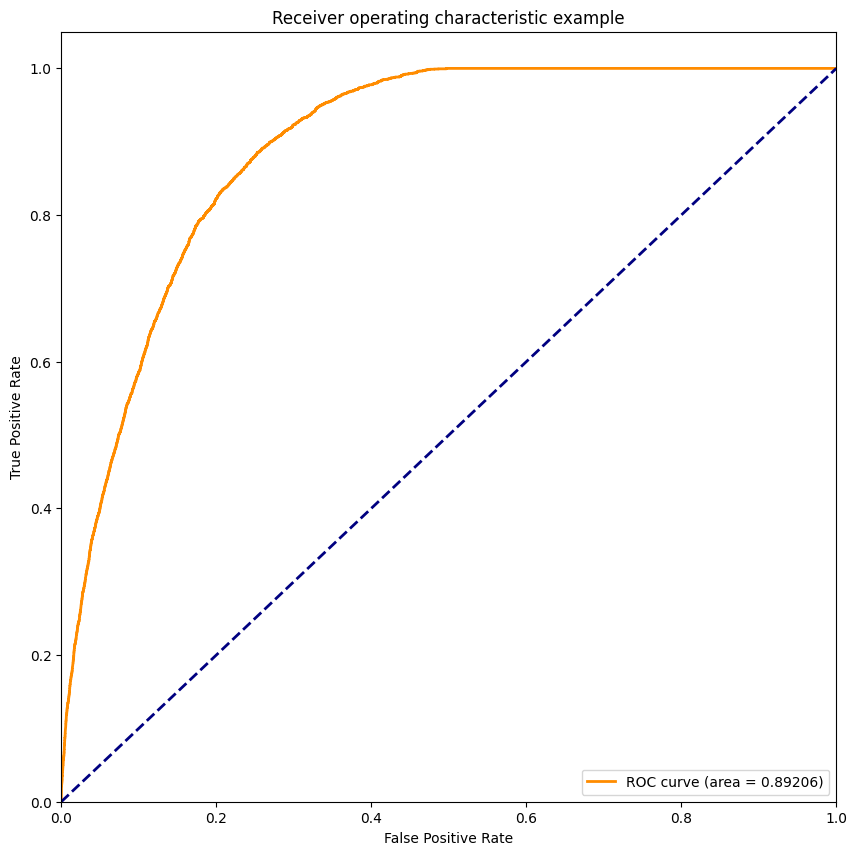

In [119]:
# Plot ROC curve

fpr, tpr, thresholds = roc_curve(y_test, xgb1_model.predict_proba(X_test)[:, xgb1_model.classes_ == 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.5f)' % roc_auc)

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])

plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')

plt.ylabel('True Positive Rate')

plt.title('Receiver operating characteristic example')

plt.legend(loc="lower right")

plt.show()

<Axes: title={'center': 'Feature importance'}, xlabel='Gain', ylabel='Features'>

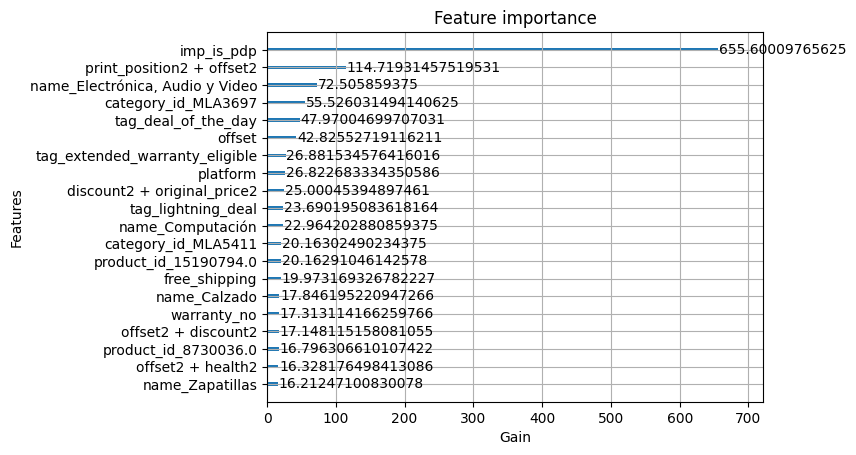

In [288]:
# Feature Importance
xgb.plot_importance(xgb1_model, max_num_features=20, importance_type="gain", xlabel="Gain")

<Axes: title={'center': 'Feature importance'}, xlabel='Cover', ylabel='Features'>

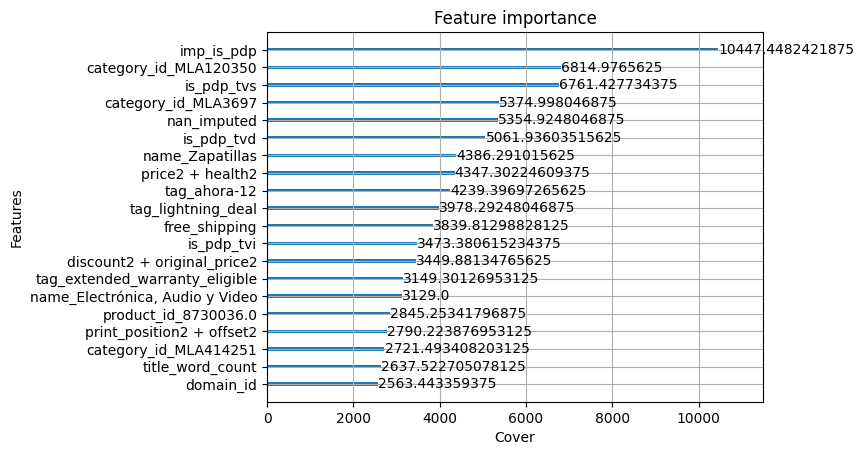

In [289]:
# Feature Importance
xgb.plot_importance(xgb1_model, max_num_features=20, importance_type="cover", xlabel="Cover")

#### Feature Importance

In [290]:
# # Get Feature Importance from the classifier xgb1_model
feature_importances = pd.DataFrame(
    xgb1_model.feature_importances_,
    index = X_train.columns,
    columns=['importance']).sort_values('importance', ascending=False)

feature_importances.head(20)

,importance
imp_is_pdp,0.324750
print_position2 + offset2,0.056826
"name_Electrónica, Audio y Video",0.035916
category_id_MLA3697,0.027505
tag_deal_of_the_day,0.023762
offset,0.021214
tag_extended_warranty_eligible,0.013316
platform,0.013287
discount2 + original_price2,0.012384
tag_lightning_deal,0.011735


In [161]:
# # Add gain column
gains = sorted(xgb1_model.get_booster().get_score(importance_type="gain").items(), key=lambda x: x[1], reverse=True)

gains_pd = pd.DataFrame(gains, columns=["feature", "gain"]).set_index("feature").sort_values("gain", ascending=False)

gains_pd.head(20)

,gain
feature,
imp_is_pdp,655.524292
print_position2 + offset2,160.699326
discount2 + original_price2,52.203117
"name_Electrónica, Audio y Video",44.868622
tag_extended_warranty_eligible,32.981644
platform,32.324631
tag_deal_of_the_day,31.714697
name_Computación,31.699148
offset,29.633434


In [48]:
feature_importances.head(20)

,importance
imp_is_pdp,0.566272
deal_of_the_day,0.045136
lightning_deal,0.022342
offset,0.021150
print_position,0.020870
incomplete_technical_specs,0.019530
platform,0.019043
benefit,0.017660
extended_warranty_eligible,0.017288
ahora-12,0.012944


### Train XGBoost Model (Top Gain params) with Cross Validation

In [167]:
xgb_wrap_model = xgb.XGBClassifier(
    objective = 'binary:logistic',
    seed = random_state,
    n_jobs=-1,
)

# reduced_cols = gains_pd.head(10).index
# reduced_cols = feature_importances.head(10).index

reduced_cols = list(set(gains_pd.head(10).index) & set(feature_importances.head(10).index))

xgb_wrap_model.fit(X_train, y_train)
roc_auc_score(y_test, xgb_wrap_model.predict_proba(X_test)[:, xgb_wrap_model.classes_ == 1])

0.8976235646368511

In [ ]:
# covers = sorted(xgb1_model.get_booster().get_score(importance_type="cover").items(), key=lambda x: x[1], reverse=True)
# covers_pd = pd.DataFrame(covers, columns=["feature", "cover"]).set_index("feature").sort_values("cover", ascending=False)


# xgb_model_covers = xgb.XGBClassifier(
#     objective = 'binary:logistic',
#     seed = random_state,
#     n_jobs=-1,
# )

# reduced_cols = covers_pd.head(20).index

# xgb_model_covers.fit(X_train[reduced_cols], y_train)

# roc_auc_score(y_test, xgb_model_covers.predict_proba(X_test[reduced_cols])[:, xgb_model_covers.classes_ == 1])

#### ROC AUC

In [ ]:
# roc_auc_score(y_test, xgb2_model.predict_proba(X_test)[:, xgb2_model.classes_ == 1])

#### Feature Importance

In [ ]:
# Feature Importance
# xgb.plot_importance(xgb2_model, max_num_features=20, importance_type="gain", xlabel="Gain")

In [ ]:
# # Feature Importance
# fig, ax = plt.subplots(figsize=(5, 20))

# xgb.plot_importance(xgb2_model, max_num_features=100, importance_type="gain", xlabel="Gain", ax=ax)

In [386]:
xgb_cv_model = xgb.XGBClassifier(
    objective = 'binary:logistic',
    seed = random_state,
    n_jobs=-1,
)

scores = cross_val_score(xgb_cv_model, X_train, y_train, cv=5, scoring="roc_auc")

score = scores.mean()

notify("XGB_CV", "Done. Score: {}".format(score))

score

0.8916139825610827

## Retrain Model with Validation Data

In [ ]:
# del comp_data
# del full_data
# gc.collect()

In [374]:
# params = {'colsample_bytree': 0.9958188825321641, 'gamma': 0.9488078042954764, 'learning_rate': 0.07108927605766976, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 4, 'subsample': 0.8232243201689888}
xgb4_model = xgb.XGBClassifier(
        # **params,
        objective = 'binary:logistic',
        seed = random_state,
        n_jobs=-1,
        verbosity=1,
)

xgb4_model.fit(X_train, y_train)

score = roc_auc_score(y_test, xgb4_model.predict_proba(X_test)[:, xgb4_model.classes_ == 1])

notify("XGB4", "Done. Score: {}".format(score))

create_submission_file(xgb4_model,
                       xgb4_model.get_booster().feature_names,
                       "outputs/xgb_pred+imp(is_pdp)+pca30_over_300_embs: {:.5f} {}.csv".format(score, datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
)

score

0.901070564226456

#### ROC AUC on X_test

In [ ]:
# roc_auc_score(y_test, xgb4_model.predict_proba(X_test)[:, xgb4_model.classes_ == 1])

#### ROC AUC on Balanced X_test (Subsampled X_test for conversion == 0)

In [ ]:
new_X_test = new_test_data.drop(columns=["conversion", "ROW_ID"])
new_X_test = new_X_test.select_dtypes(include='number')

new_y_test = new_test_data["conversion"]

# roc_auc_score(new_y_test, xgb2_model.predict_proba(new_X_test)[:, xgb2_model.classes_ == 1])

#### Confusion Matrix

In [ ]:
# # Confusion Matrix for xgb2_model on new_test_data

# conf_mx = confusion_matrix(new_y_test, xgb2_model.predict(new_X_test))

# true_neg, false_pos, false_neg, true_pos = conf_mx.ravel()

# true_neg, false_pos, false_neg, true_pos

In [ ]:
""" xgb3_model = make_pipeline(
    SimpleImputer(strategy="median"),
    xgb.XGBClassifier(
        objective = 'binary:logistic',
        seed = random_state,
        n_jobs=-1,
    )
)

xgb3_model.fit(X_train, y_train)

roc_auc_score(y_test, xgb3_model.predict_proba(X_test)[:, xgb3_model.classes_ == 1]) """

' xgb3_model = make_pipeline(\n    SimpleImputer(strategy="median"),\n    xgb.XGBClassifier(\n        objective = \'binary:logistic\',\n        seed = random_state,\n        n_jobs=-1,\n    )\n)\n\nxgb3_model.fit(X_train, y_train)\n\nroc_auc_score(y_test, xgb3_model.predict_proba(X_test)[:, xgb3_model.classes_ == 1]) '

### Random Forest

In [307]:
rfc = make_pipeline(
    SimpleImputer(strategy="median"),
    RandomForestClassifier()
)

# rfc.fit(X_train, y_train)

# roc_auc_score(y_test, rfc.predict_proba(X_test)[:, rfc.classes_ == 1])

0.8701880145107637

### Voting Classifier (XGBoost + Random Forest)

In [294]:
voting_rfc_xgb = VotingClassifier(
    estimators=[
        ("rfc", rfc),
        ("xgb", xgb4_model)
    ],
    voting="soft",
    n_jobs=-1
)

# voting_rfc_xgb.fit(X_train, y_train)

# roc_auc_score(y_test, voting_rfc_xgb.predict_proba(X_test)[:, voting_rfc_xgb.classes_ == 1])

### GradientBoostingClassifier

In [308]:
gbc = make_pipeline(
    SimpleImputer(strategy="median"),
    GradientBoostingClassifier(verbose=2)
)

# gbc.fit(X_train, y_train)

# score = roc_auc_score(y_test, gbc.predict_proba(X_test)[:, gbc.classes_ == 1])

# notify("GBC", "Done. Score: {}".format(score))

# score

      Iter       Train Loss   Remaining Time 
         1           0.5884            3.06m
         2           0.5673            3.06m
         3           0.5505            3.02m
         4           0.5366            3.00m
         5           0.5254            3.18m
         6           0.5156            3.10m
         7           0.5073            3.04m
         8           0.5001            2.99m
         9           0.4940            2.94m
        10           0.4886            2.97m
        11           0.4838            2.93m
        12           0.4795            2.96m
        13           0.4757            2.91m
        14           0.4723            2.86m
        15           0.4693            2.81m
        16           0.4667            2.77m
        17           0.4636            2.73m
        18           0.4615            2.73m
        19           0.4591            2.73m
        20           0.4575            2.74m
        21           0.4565            2.74m
        2

0.8830275041783998

### HistGradientBoostingClassifier

In [309]:
hgb = HistGradientBoostingClassifier(verbose=2)

hgb.fit(X_train, y_train)

# score = roc_auc_score(y_test, hgb.predict_proba(X_test)[:, hgb.classes_ == 1])

# notify("HGB", "Done. Score: {}".format(score))

# score

Binning 0.170 GB of training data: 1.911 s
Binning 0.019 GB of validation data: 0.034 s
Fitting gradient boosted rounds:
[1/100] 1 tree, 31 leaves, max depth = 12, train loss: 0.29030, val loss: 0.29004, in 0.064s
[2/100] 1 tree, 31 leaves, max depth = 10, train loss: 0.27771, val loss: 0.27736, in 0.062s
[3/100] 1 tree, 31 leaves, max depth = 11, train loss: 0.26818, val loss: 0.26795, in 0.056s
[4/100] 1 tree, 31 leaves, max depth = 11, train loss: 0.26056, val loss: 0.26014, in 0.056s
[5/100] 1 tree, 31 leaves, max depth = 13, train loss: 0.25426, val loss: 0.25382, in 0.068s
[6/100] 1 tree, 31 leaves, max depth = 9, train loss: 0.24896, val loss: 0.24849, in 0.075s
[7/100] 1 tree, 31 leaves, max depth = 8, train loss: 0.24434, val loss: 0.24407, in 0.061s
[8/100] 1 tree, 31 leaves, max depth = 10, train loss: 0.24041, val loss: 0.24015, in 0.061s
[9/100] 1 tree, 31 leaves, max depth = 9, train loss: 0.23683, val loss: 0.23661, in 0.058s
[10/100] 1 tree, 31 leaves, max depth = 9, tr

0.8945825975199084

### AdaBoostClassifier

In [311]:
abc = make_pipeline(
    SimpleImputer(strategy="median"),
    AdaBoostClassifier()
)

# abc.fit(X_train, y_train)

# score = roc_auc_score(y_test, abc.predict_proba(X_test)[:, abc.classes_ == 1])

# notify("ABC", "Done. Score: {}".format(score))

# score

0.8817992335852044

### ExtraTreesClassifier

In [310]:
etc = make_pipeline(
    SimpleImputer(strategy="median"),
    ExtraTreesClassifier()
)

# etc.fit(X_train, y_train)

# score = roc_auc_score(y_test, etc.predict_proba(X_test)[:, etc.classes_ == 1])

# notify("ETC", "Done. Score: {}".format(score))

# score

0.8665800001758679

### Voting Classifier Alt

In [299]:
voting_alt = VotingClassifier(
    estimators=[
        # ("rfc", rfc),
        ("xgb", xgb4_model),
        ("hgb", hgb),
        ("abc", abc),
    ],
    voting="soft",
    n_jobs=-1,
)

# voting_alt.fit(X_train, y_train)

# score = roc_auc_score(y_test, voting_alt.predict_proba(X_test)[:, voting_alt.classes_ == 1])

# notify("Voting Alt", "Done. Score: {}".format(score))

# create_submission_file(voting_alt,
#                        xgb4_model.get_booster().feature_names, 
#                        "outputs/submission_voting(rfc, xgb, hgb, abc): {:.5f}.csv".format(score)
# )

# score

In [132]:
voting_alt

VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            gpu_id=None, grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_ra...
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=100, n_jobs=-1,
                                            num_parallel_tree=None,
                                            predictor=None, random_state=None, ...)),
                             ('hgb', HistGradientBoostingClassifier(verbose=2)),
                             ('abc',
                              Pipeline(steps=[('simpleimputer',
                                               SimpleImputer(strategy='median')),
                                              ('adaboostclassifier',
                                               AdaBoostClassifier())]))],
                 n_jobs=-1, voting='soft')

### Average Classifier

In [300]:
# average classifier
from sklearn.utils._pprint import _EstimatorPrettyPrinter

class AverageClassifier:
    def __init__(self, models):
        self.models = models
        self.classes_ = models[0].classes_

    def predict_proba(self, X):
        return np.mean([model.predict_proba(X) for model in self.models], axis=0)

    def predict(self, X):
        return np.mean([model.predict(X) for model in self.models], axis=0)

    def fit(self, X, y):
        for model in self.models:
            model.fit(X, y)

    def __repr__(self, N_CHAR_MAX=700):
        # N_CHAR_MAX is the (approximate) maximum number of non-blank
        # characters to render. We pass it as an optional parameter to ease
        # the tests.

        # Using _EstimatorPrettyPrinter

        pp = _EstimatorPrettyPrinter(
            compact=True,
            indent=1,
            indent_at_name=True,
            n_max_elements_to_show=N_MAX_ELEMENTS_TO_SHOW,
        )

        repr_ = pp.pformat(self)

        return repr_
        

In [312]:
average_classifier = AverageClassifier(
    [
        #rfc,
        xgb4_model,
        hgb,
        abc,
        #voting_alt
    ]
)

# average_classifier.fit(X_train, y_train)

# score = roc_auc_score(y_test, average_classifier.predict_proba(X_test)[:, average_classifier.classes_ == 1])

# notify("AVG", "Done. Score: {}".format(score))

# create_submission_file(average_classifier, 
#                        xgb4_model.get_booster().feature_names, 
#                        "outputs/submission_avg(xgb, hgb, abc): {:.5f}.csv".format(score)
# )

# score

Binning 0.170 GB of training data: 1.762 s
Binning 0.019 GB of validation data: 0.034 s
Fitting gradient boosted rounds:
[1/100] 1 tree, 31 leaves, max depth = 11, train loss: 0.29008, val loss: 0.29109, in 0.074s
[2/100] 1 tree, 31 leaves, max depth = 10, train loss: 0.27740, val loss: 0.27915, in 0.070s
[3/100] 1 tree, 31 leaves, max depth = 11, train loss: 0.26783, val loss: 0.27019, in 0.073s
[4/100] 1 tree, 31 leaves, max depth = 10, train loss: 0.26019, val loss: 0.26282, in 0.074s
[5/100] 1 tree, 31 leaves, max depth = 11, train loss: 0.25387, val loss: 0.25688, in 0.070s
[6/100] 1 tree, 31 leaves, max depth = 11, train loss: 0.24856, val loss: 0.25199, in 0.083s
[7/100] 1 tree, 31 leaves, max depth = 13, train loss: 0.24398, val loss: 0.24765, in 0.098s
[8/100] 1 tree, 31 leaves, max depth = 12, train loss: 0.24003, val loss: 0.24397, in 0.152s
[9/100] 1 tree, 31 leaves, max depth = 10, train loss: 0.23639, val loss: 0.24057, in 0.067s
[10/100] 1 tree, 31 leaves, max depth = 9,

0.8983430623365103

### Stacking Classifier

In [375]:
# Stacking Classifier

stacking_classifier = StackingClassifier(
    estimators=[
        #("rfc", rfc),
        ("xgb", xgb4_model),
        ("hgb", hgb),
        ("abc", abc),
    ],
    final_estimator=LogisticRegression(),
    n_jobs=-1,
    stack_method="predict_proba",
    verbose=2
)

stacking_classifier.fit(X_train, y_train)

score = roc_auc_score(y_test, stacking_classifier.predict_proba(X_test)[:, stacking_classifier.classes_ == 1])

notify("STACK", "Done. Score: {}".format(score))

create_submission_file(stacking_classifier,
                       xgb4_model.get_booster().feature_names, 
                       "outputs/submission_stack(xgb, hgb, abc)_polyfeat_imp_pred_pdp+pca_embs: {:.5f} {}.csv".format(score, datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
)

score

Binning 0.225 GB of training data: 5.244 s
Binning 0.025 GB of validation data: 0.185 s
Fitting gradient boosted rounds:
[1/100] 1 tree, 31 leaves, max depth = 10, train loss: 0.51411, val loss: 0.51459, in 0.354s
[2/100] 1 tree, 31 leaves, max depth = 10, train loss: 0.48950, val loss: 0.49052, in 0.240s
[3/100] 1 tree, 31 leaves, max depth = 9, train loss: 0.46976, val loss: 0.47118, in 0.223s
[4/100] 1 tree, 31 leaves, max depth = 10, train loss: 0.45330, val loss: 0.45514, in 0.239s
[5/100] 1 tree, 31 leaves, max depth = 10, train loss: 0.43948, val loss: 0.44163, in 0.208s
[6/100] 1 tree, 31 leaves, max depth = 11, train loss: 0.42757, val loss: 0.42990, in 0.336s
[7/100] 1 tree, 31 leaves, max depth = 8, train loss: 0.41752, val loss: 0.42021, in 0.267s
[8/100] 1 tree, 31 leaves, max depth = 10, train loss: 0.40874, val loss: 0.41169, in 0.202s
[9/100] 1 tree, 31 leaves, max depth = 9, train loss: 0.40108, val loss: 0.40419, in 0.249s
[10/100] 1 tree, 31 leaves, max depth = 9, tr

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Binning 0.180 GB of training data: 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Binning 0.180 GB of training data: 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Binning 0.180 GB of training data: Binning 0.180 GB of training data: Binning 0.180 GB of training data: 17.756 s
Binning 0.020 GB of validation data: 0.599 s
Fitting gradient boosted rounds:
[1/100] 18.041 s
Binning 0.020 GB of validation data: 1 tree, 31 leaves, max depth = 9, train loss: 0.51419, val loss: 0.51419, in 0.715s
[2/100] 18.154 s
Binning 0.020 GB of validation data: 0.686 s
18.965 s
Binning 0.020 GB of validation data: Fitting gradient boosted rounds:
[1/100] 18.917 s
Binning 0.020 GB of validation data: 1 tree, 31 leaves, max depth = 10, train loss: 0.48981, val loss: 0.48976, in 1.099s
[3/100] 0.949 s
0.915 s
Fitting gradient boosted rounds:
[1/100] Fitting gradient boosted rounds:
[1/100] 1 tree, 31 leaves, max depth = 10, train loss: 0.51412, val loss: 0.51483, in 0.993s
[2/100] 0.862 s
Fitting gradient boosted rounds:
[1/100] 1 tree, 31 leaves, max depth = 10, train loss: 0.46990, val loss: 0.47007, in 0.658s
[4/100] 1 tree, 31 leaves, max depth = 9, train loss: 0.5

[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.1min remaining:  1.6min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.1min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.1min finished
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.5min remaining:  3.7min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.5min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.5min finished
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  4.6min remaining:  6.8min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.6min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.6min finished


0.897480262381363

In [ ]:
stacking_classifier

StackingClassifier(estimators=[('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              feature_types=None, gamma=None,
                                              gpu_id=None, grow_policy=None,
                                              importance_type=None,
                                              interaction_constraints=None,
                                              learning_...
                                              max_cat_to_onehot=None,
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              n_estimators=100, n_jobs=-1,
                                              num_parallel_tree=None,
                                              predictor=None, random_state=None, ...)),
                               ('hgb',
                                HistGradientBoostingClassifier(verbose=2))],
                   final_estimator=LogisticRegression(), n_jobs=-1,
                   stack_method='predict_proba', verbose=2)

In [302]:
# Stacking Classifier

# ideas for final_estimator
# - LogisticRegression
# - XGBClassifier
# - RandomForestClassifier
# - GradientBoostingClassifier


stacking_classifier_2 = StackingClassifier(
    estimators=[
        ("xgb", xgb4_model),
        ("hgb", hgb),
        ("abc", abc),
    ],
    final_estimator=xgb.XGBClassifier(
        objective = 'binary:logistic',
        seed = random_state,
        n_jobs=-1,
    ),
    n_jobs=-1,
    stack_method="predict_proba",
    verbose=2
)

# stacking_classifier_2.fit(X_train, y_train)

# score = roc_auc_score(y_test, stacking_classifier_2.predict_proba(X_test)[:, stacking_classifier_2.classes_ == 1])

# notify("STACK2", "Done. Score: {}".format(score))

# create_submission_file(stacking_classifier_2,
#                           xgb4_model.get_booster().feature_names,
#                             "outputs/submission_stack2(xgb, hgb, abc)_polyfeat_imp_pred_pdp_pca_embs: {:.5f} {}.csv".format(score, datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
# )

# score

Binning 0.170 GB of training data: 2.807 s
Binning 0.019 GB of validation data: 0.084 s
Fitting gradient boosted rounds:
[1/100] 1 tree, 31 leaves, max depth = 12, train loss: 0.29015, val loss: 0.29107, in 0.148s
[2/100] 1 tree, 31 leaves, max depth = 11, train loss: 0.27754, val loss: 0.27897, in 0.139s
[3/100] 1 tree, 31 leaves, max depth = 11, train loss: 0.26795, val loss: 0.26979, in 0.145s
[4/100] 1 tree, 31 leaves, max depth = 10, train loss: 0.26025, val loss: 0.26241, in 0.142s
[5/100] 1 tree, 31 leaves, max depth = 9, train loss: 0.25394, val loss: 0.25655, in 0.142s
[6/100] 1 tree, 31 leaves, max depth = 13, train loss: 0.24861, val loss: 0.25151, in 0.138s
[7/100] 1 tree, 31 leaves, max depth = 13, train loss: 0.24399, val loss: 0.24725, in 0.149s
[8/100] 1 tree, 31 leaves, max depth = 10, train loss: 0.24008, val loss: 0.24370, in 0.137s
[9/100] 1 tree, 31 leaves, max depth = 10, train loss: 0.23660, val loss: 0.24060, in 0.134s
[10/100] 1 tree, 31 leaves, max depth = 12,

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Binning 0.136 GB of training data: Binning 0.136 GB of training data: Binning 0.136 GB of training data: Binning 0.136 GB of training data: Binning 0.136 GB of training data: 8.260 s
Binning 0.015 GB of validation data: 0.210 s
Fitting gradient boosted rounds:
[1/100] 8.395 s
Binning 0.015 GB of validation data: 1 tree, 31 leaves, max depth = 12, train loss: 0.28980, val loss: 0.29063, in 0.441s
[2/100] 8.492 s
Binning 0.015 GB of validation data: 0.298 s
Fitting gradient boosted rounds:
[1/100] 8.554 s
Binning 0.015 GB of validation data: 8.602 s
Binning 0.015 GB of validation data: 0.338 s
Fitting gradient boosted rounds:
[1/100] 1 tree, 31 leaves, max depth = 11, train loss: 0.27715, val loss: 0.27855, in 0.418s
[3/100] 0.304 s0.346 s

Fitting gradient boosted rounds:
1 tree, 31 leaves, max depth = 11, train loss: 0.29006, val loss: 0.29100, in 0.377s
[2/100] [1/100] Fitting gradient boosted rounds:
[1/100] 1 tree, 31 leaves, max depth = 12, train loss: 0.29005, val loss: 0.29051, i

[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   41.8s remaining:  1.0min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   42.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   42.4s finished
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.8min remaining:  2.6min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.8min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.8min finished
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  3.3min remaining:  4.9min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.3min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.3min finished


0.8952670663933405

In [ ]:
# average_classifier2 = AverageClassifier([voting_alt, stacking_classifier])

# # average_classifier.fit(X_train, y_train)

# roc_auc_score(y_test, average_classifier2.predict_proba(X_test)[:, average_classifier2.classes_ == 1])

### Logistic Regression

In [ ]:
# # Logistic Regression

# logistic_regression = make_pipeline(
#     SimpleImputer(strategy="median"),
#     LogisticRegression(
#         n_jobs=-1
#     )
# )

# best_score = 0
# best_cut = 0
# for i in range(1, 20):

#     logistic_regression.fit(X_train[reduced_cols[:i]], y_train)

#     score = roc_auc_score(y_test, logistic_regression.predict_proba(X_test[reduced_cols[:i]])[:, logistic_regression.classes_ == 1])

#     print(i, score)

#     if score > best_score:
#         best_score = score
#         best_cut = i

# best_score, best_cut

In [ ]:
# logistic_regression = make_pipeline(
#     SimpleImputer(strategy="median"),
#     PolynomialFeatures(degree=2, include_bias=False, interaction_only=True),
#     LogisticRegression(
#         n_jobs=-1,
#         max_iter=1000
#     )
# )

# logistic_regression.fit(X_train[reduced_cols[:3]], y_train)

# roc_auc_score(y_test, logistic_regression.predict_proba(X_test[reduced_cols[:3]])[:, logistic_regression.classes_ == 1])

In [ ]:
# bagging_classifier_rfc = make_pipeline(
#     SimpleImputer(strategy="median"),
#     BaggingClassifier(
#         base_estimator=RandomForestClassifier(),
#         n_estimators=10,
#         n_jobs=-1
#     )
# )

# bagging_classifier_rfc.fit(X_train, y_train)

# roc_auc_score(y_test, bagging_classifier_rfc.predict_proba(X_test)[:, bagging_classifier_rfc.classes_ == 1])

In [ ]:
# bagging_classifier_logistic = BaggingClassifier(
#     estimator=LogisticRegression(
#         n_jobs=-1,
#         max_iter=1000
#     ),
#     n_estimators=10,
#     n_jobs=-1
# )

# bagging_classifier_logistic.fit(X_train[reduced_cols[:best_cut]], y_train)

# roc_auc_score(y_test, bagging_classifier_logistic.predict_proba(X_test[reduced_cols[:best_cut]])[:, bagging_classifier_logistic.classes_ == 1])

In [356]:
bagging_classifier_xgb = BaggingClassifier(
    estimator=xgb.XGBClassifier(
        objective = 'binary:logistic',
        seed = random_state,
        n_jobs=-1,
    ),
    n_estimators=10,
    n_jobs=-1,
    verbose=20,
)

bagging_classifier_xgb.fit(X_train, y_train)

score = roc_auc_score(y_test, bagging_classifier_xgb.predict_proba(X_test)[:, bagging_classifier_xgb.classes_ == 1])

notify("BAGGING XGB", "Done. Score: {}".format(score))

create_submission_file(bagging_classifier_xgb,
                          xgb4_model.get_booster().feature_names,
                            "outputs/submission_bagging_xgb_polyfeat_imp_pred_pdp_pca_embs: {:.5f} {}.csv".format(score, datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
)

score

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


Building estimator 1 of 2 for this parallel run (total 10)...
Building estimator 1 of 1 for this parallel run (total 10)...
Building estimator 1 of 1 for this parallel run (total 10)...
Building estimator 1 of 1 for this parallel run (total 10)...
Building estimator 1 of 1 for this parallel run (total 10)...
Building estimator 1 of 2 for this parallel run (total 10)...
Building estimator 1 of 1 for this parallel run (total 10)...
Building estimator 1 of 1 for this parallel run (total 10)...
Building estimator 2 of 2 for this parallel run (total 10)...


[Parallel(n_jobs=8)]: Done   1 tasks      | elapsed:  1.2min
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  1.2min remaining:  3.5min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  1.2min remaining:  2.0min
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  1.2min remaining:  1.2min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  1.2min remaining:   42.7s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  1.2min remaining:   23.9s


Building estimator 2 of 2 for this parallel run (total 10)...


[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.8min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.8min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   1 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.6s remaining:    1.7s
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.6s remaining:    1.0s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.6s remaining:    0.6s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.6s remaining:    0.4s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.6s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done  

0.8964161587255347

In [ ]:
# Feature Importance
xgb.plot_importance(bagging_classifier_xgb.estimators_[0], max_num_features=20, importance_type="gain", xlabel="Gain")

In [ ]:
# stacking_classifier_2 = StackingClassifier(
#     estimators=[
#         ("rfc", rfc),
#         ("xgb", xgb4_model),
#         ("hgb", hgb),
#         ("abc", abc),
#         ("bg_xgb", bagging_classifier_xgb),
#     ],
#     final_estimator=LogisticRegression(),
#     n_jobs=-1
# )

# stacking_classifier_2.fit(X_train, y_train)

# roc_auc_score(y_test, stacking_classifier_2.predict_proba(X_test)[:, stacking_classifier_2.classes_ == 1])

In [304]:
voting_alt_2 = VotingClassifier(
    estimators=[
        ("rfc", rfc),
        ("xgb", xgb4_model),
        ("hgb", hgb),
        ("abc", abc),
        ("bg_xgb", bagging_classifier_xgb),
    ],
    voting="soft",
    n_jobs=-1
)

voting_alt_2.fit(X_train, y_train)

score = roc_auc_score(y_test, voting_alt_2.predict_proba(X_test)[:, voting_alt_2.classes_ == 1])

notify("Voting Alt 2", "Done. Score: {}".format(score))

create_submission_file(voting_alt_2,
                            xgb4_model.get_booster().feature_names,
                                "outputs/submission_voting_alt2(rfc, xgb, hgb, abc, bg_xgb)_polyfeat_imp_pred_pdp_pca_embs: {:.5f} {}.csv".format(score, datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
    )

score

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Building estimator 1 of 2 for this parallel run (total 10)...Building estimator 1 of 2 for this parallel run (total 10)...

Building estimator 1 of 1 for this parallel run (total 10)...
Building estimator 1 of 1 for this parallel run (total 10)...
Building estimator 1 of 1 for this parallel run (total 10)...
Building estimator 1 of 1 for this parallel run (total 10)...
Building estimator 1 of 1 for this parallel run (total 10)...
Building estimator 1 of 1 for this parallel run (total 10)...
Binning 0.170 GB of training data: 6.959 s
Binning 0.019 GB of validation data: 0.307 s
Fitting gradient boosted rounds:
[1/100] 1 tree, 31 leaves, max depth = 11, train loss: 0.29000, val loss: 0.29134, in 0.301s
[2/100] 1 tree, 31 leaves, max depth = 11, train loss: 0.27741, val loss: 0.27938, in 0.316s
[3/100] 1 tree, 31 leaves, max depth = 11, train loss: 0.26780, val loss: 0.27019, in 0.314s
[4/100] 1 tree, 31 leaves, max depth = 12, train loss: 0.26003, val loss: 0.26290, in 0.333s
[5/100] 1 t

[Parallel(n_jobs=8)]: Done   1 tasks      | elapsed:  5.4min
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  5.4min remaining: 16.1min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  5.4min remaining:  9.0min


Building estimator 2 of 2 for this parallel run (total 10)...


[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  5.4min remaining:  5.4min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  5.4min remaining:  3.2min
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  5.4min remaining:  1.8min
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  7.8min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  7.8min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   1 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.8s remaining:    2.5s
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.8s remaining:    1.4s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    1.9s remaining:    1.9s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    1.9s remaining:    1.1s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    1.9s remaining:    0.6s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.9s remaining:   

0.9016326644600676

In [ ]:
# average_classifier_3 = AverageClassifier([voting_alt_2, stacking_classifier_2])

# average_classifier_3.fit(X_train, y_train)

# roc_auc_score(y_test, average_classifier_3.predict_proba(X_test)[:, average_classifier_3.classes_ == 1])

In [ ]:
y_train[y_train == True].shape[0], y_train[y_train == False].shape[0]

(12555, 123015)

In [306]:
voting_3 = VotingClassifier(
    estimators=[
        ("rfc", rfc),
        # ("xgb", xgb4_model),
        ("hgb", hgb),
        ("abc", abc),
        ("bg_xgb", bagging_classifier_xgb),
        ("stack", stacking_classifier)
    ],
    voting="soft",
    n_jobs=-1
)

voting_3.fit(X_train, y_train)

score = roc_auc_score(y_test, voting_3.predict_proba(X_test)[:, voting_3.classes_ == 1])

notify("Voting Alt 2", "Done. Score: {}".format(score))

create_submission_file(voting_3,
                            xgb4_model.get_booster().feature_names,
                                "outputs/submission_voting_3(rfc, hgb, abc, bg_xgb, stack)_polyfeat_imp_pred_pdp_pca_embs: {:.5f} {}.csv".format(score, datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
    )

score

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Building estimator 1 of 2 for this parallel run (total 10)...
Building estimator 1 of 2 for this parallel run (total 10)...
Building estimator 1 of 1 for this parallel run (total 10)...Building estimator 1 of 1 for this parallel run (total 10)...
Building estimator 1 of 1 for this parallel run (total 10)...
Building estimator 1 of 1 for this parallel run (total 10)...
Building estimator 1 of 1 for this parallel run (total 10)...
Building estimator 1 of 1 for this parallel run (total 10)...

Binning 0.170 GB of training data: Binning 0.170 GB of training data: 10.178 s
Binning 0.019 GB of validation data: 10.329 s
Binning 0.019 GB of validation data: 0.323 s
Fitting gradient boosted rounds:
[1/100] 0.298 s
Fitting gradient boosted rounds:
[1/100] 1 tree, 31 leaves, max depth = 11, train loss: 0.29008, val loss: 0.29087, in 0.452s
[2/100] 1 tree, 31 leaves, max depth = 12, train loss: 0.29029, val loss: 0.29001, in 0.477s
[2/100] 1 tree, 31 leaves, max depth = 13, train loss: 0.27745, va

[Parallel(n_jobs=8)]: Done   1 tasks      | elapsed:  5.4min
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:  5.4min remaining: 16.3min
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:  5.4min remaining:  9.1min
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:  5.4min remaining:  5.4min
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:  5.4min remaining:  3.3min
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


Binning 0.136 GB of training data: 

[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:  5.4min remaining:  1.8min


Building estimator 2 of 2 for this parallel run (total 10)...
2.488 s
Binning 0.015 GB of validation data: 0.082 s
Fitting gradient boosted rounds:
[1/100] 1 tree, 31 leaves, max depth = 12, train loss: 0.28987, val loss: 0.29119, in 0.137s
[2/100] 1 tree, 31 leaves, max depth = 12, train loss: 0.27729, val loss: 0.27905, in 0.134s
[3/100] 1 tree, 31 leaves, max depth = 12, train loss: 0.26777, val loss: 0.27014, in 0.123s
[4/100] 1 tree, 31 leaves, max depth = 13, train loss: 0.25986, val loss: 0.26269, in 0.117s
[5/100] 1 tree, 31 leaves, max depth = 12, train loss: 0.25344, val loss: 0.25664, in 0.141s
[6/100] 1 tree, 31 leaves, max depth = 10, train loss: 0.24810, val loss: 0.25168, in 0.133s
[7/100] 1 tree, 31 leaves, max depth = 11, train loss: 0.24350, val loss: 0.24729, in 0.145s
[8/100] 1 tree, 31 leaves, max depth = 9, train loss: 0.23936, val loss: 0.24344, in 0.128s
[9/100] 1 tree, 31 leaves, max depth = 11, train loss: 0.23584, val loss: 0.24025, in 0.128s
[10/100] 1 tree,

[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   13.8s remaining:    0.0s


Binning 0.136 GB of training data: 2.269 s
Binning 0.015 GB of validation data: 0.073 s
Fitting gradient boosted rounds:
[1/100] 1 tree, 31 leaves, max depth = 12, train loss: 0.28981, val loss: 0.29081, in 0.120s
[2/100] 1 tree, 31 leaves, max depth = 10, train loss: 0.27720, val loss: 0.27896, in 0.118s
[3/100] 1 tree, 31 leaves, max depth = 10, train loss: 0.26760, val loss: 0.27016, in 0.113s
[4/100] 1 tree, 31 leaves, max depth = 9, train loss: 0.25992, val loss: 0.26305, in 0.122s
[5/100] 1 tree, 31 leaves, max depth = 12, train loss: 0.25362, val loss: 0.25707, in 0.138s
[6/100] 1 tree, 31 leaves, max depth = 9, train loss: 0.24833, val loss: 0.25224, in 0.136s
[7/100] 1 tree, 31 leaves, max depth = 9, train loss: 0.24371, val loss: 0.24810, in 0.119s
[8/100] 1 tree, 31 leaves, max depth = 9, train loss: 0.23973, val loss: 0.24461, in 0.141s
[9/100] 1 tree, 31 leaves, max depth = 9, train loss: 0.23607, val loss: 0.24108, in 0.122s
[10/100] 1 tree, 31 leaves, max depth = 10, tra

[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   52.8s remaining:    0.0s


1 tree, 31 leaves, max depth = 9, train loss: 0.18481, val loss: 0.20620, in 0.093s
[94/100] 1 tree, 31 leaves, max depth = 11, train loss: 0.18461, val loss: 0.20618, in 0.106s
[95/100] 1 tree, 31 leaves, max depth = 13, train loss: 0.18432, val loss: 0.20614, in 0.096s
[96/100] 1 tree, 31 leaves, max depth = 14, train loss: 0.18408, val loss: 0.20612, in 0.110s
[97/100] 1 tree, 31 leaves, max depth = 12, train loss: 0.18383, val loss: 0.20601, in 0.101s
[98/100] 1 tree, 31 leaves, max depth = 10, train loss: 0.18364, val loss: 0.20599, in 0.065s
[99/100] 1 tree, 31 leaves, max depth = 12, train loss: 0.18342, val loss: 0.20598, in 0.079s
[100/100] 1 tree, 31 leaves, max depth = 10, train loss: 0.18326, val loss: 0.20598, in 0.067s
Fit 100 trees in 13.220 s, (3100 total leaves)
Time spent computing histograms: 8.994s
Time spent finding best splits:  0.499s
Time spent applying splits:      0.333s
Time spent predicting:           0.016s
Binning 0.136 GB of training data: 2.406 s
Binning

[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.1min finished
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  2.2min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  8.1min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  8.1min finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.8min finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  9.8min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   1 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    2.0s remaining:    6.1s
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    2.0s remaining:    3.4s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    2.0s remaining:    2.0s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    2.1s remaining:    1.2s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    2.1s remaining:    0.7s
[Parallel(n_jobs=8)]

0.901256511679671

#### ROC AUC Curves

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   1 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.5s remaining:    1.6s
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.5s remaining:    0.9s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    0.6s remaining:    0.6s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.6s remaining:    0.3s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    0.6s remaining:    0.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   1 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.4s remaining:    1.3s
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.5s remaining:    0.8s
[Parallel(n_jobs=8

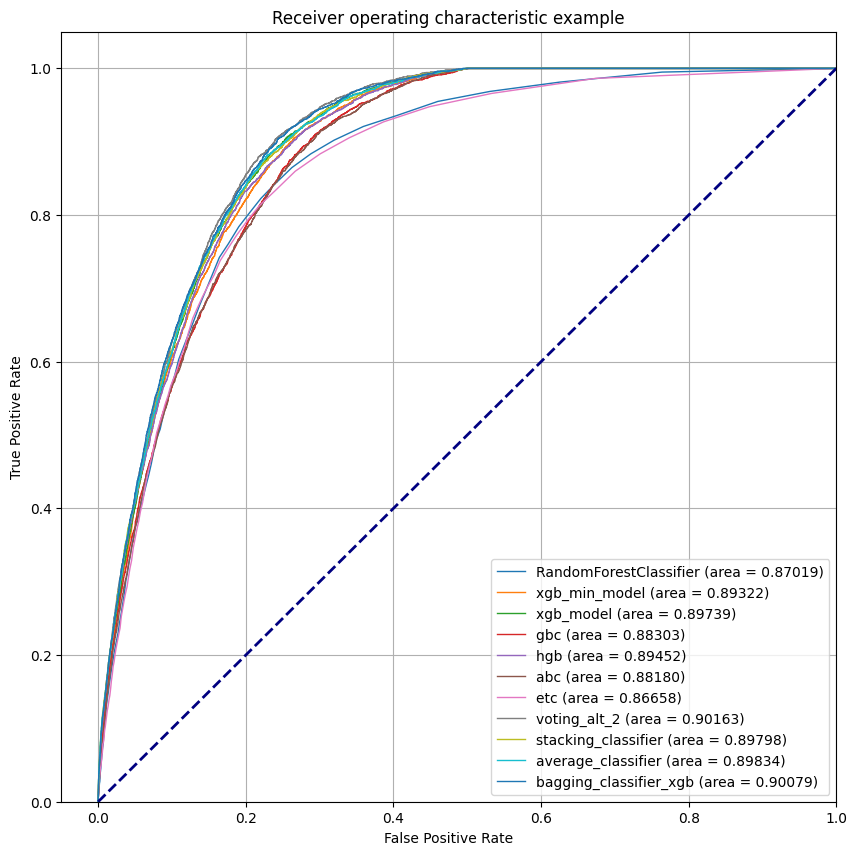

In [323]:
models = [
    #(logistic_regression, "logistic_regression"),
    (rfc, "RandomForestClassifier"),
    (xgb1_model, "xgb_min_model"),
    #(xgb_wrap_model, "xgb_wrap_model"),
    (xgb4_model, "xgb_model"), 
    #(voting_rfc_xgb, "voting_rfc_xgb"), 
    (gbc, "gbc"), 
    (hgb, "hgb"),
    (abc, "abc"), 
    (etc, "etc"), 
    #(voting_alt, "voting_alt"),
    (voting_alt_2, "voting_alt_2"),
    (stacking_classifier, "stacking_classifier"),
    # (stacking_classifier_2, "stacking_classifier_2"),
    (average_classifier, "average_classifier"),
    #(average_classifier2, "average_classifier2"),
    # (average_classifier_3, "average_classifier_3"),
    # (bagging_classifier_rfc, "bagging_classifier_rfc"),
    # (bagging_classifier_logistic, "bagging_classifier_logistic"),
    (bagging_classifier_xgb, "bagging_classifier_xgb"),
]

model_names = [model[1] for model in models]
models = [model[0] for model in models]

fig, ax = plt.subplots(figsize=(10, 10))

# plot_roc_curves(models, model_names, new_X_test, new_y_test, ax=ax)
plot_roc_curves(models, model_names, X_test, y_test, ax=ax)

fig.tight_layout()

## Hyperopt for XGBoost Model

In [388]:
hp_tune = True

In [389]:
# XGBoost with Hyperopt
if hp_tune:

    xgb_space = {
        "max_depth": hp.choice("max_depth", [2, 4, 8, 16, 32, 64, 128, None]),
        "learning_rate": hp.uniform("learning_rate", 0.01, 0.2),
        "n_estimators": hp.choice("n_estimators", [10, 50, 100, 200, 500]),
        "colsample_bytree": hp.uniform("colsample_bytree", 0.5, 1),
        "gamma": hp.uniform("gamma", 0, 1),
        "min_child_weight": hp.choice("min_child_weight", [2, 4, 8, 16, 32, 64, 128]),
        "subsample": hp.uniform("subsample", 0.5, 1),
    }

    best_score = 0
    def objective_xgb(params):
        global best_score

        model_2_opt = xgb.XGBClassifier(
            **params,
            objective = 'binary:logistic',
            seed = random_state,
            n_jobs=-1,
            #eval_metric = 'auc',
        )
        
        score = cross_val_score(model_2_opt, X_train, y_train, cv=5, scoring="roc_auc").mean()

        #model.fit(X_train_sub, y_train_sub, eval_set=[(X_val, y_val)], verbose=0)
        #model.fit(X_train, y_train)
        #score = roc_auc_score(y_test, model.predict_proba(X_test)[:, model.classes_ == 1])

        print(f"Score: {score}", params)

        if score > best_score:
            best_score = score
            print(f"New best score: {best_score}")
            print(params)
            
        return {"loss": 1 - score, "status": STATUS_OK}

    trials_xgb = Trials()

    best_xgb = fmin(
        fn=objective_xgb,
        space=xgb_space,
        algo=tpe.suggest,
        max_evals=100,
        trials=trials_xgb,
        verbose=2,
    )

    print(best_xgb)

  0%|          | 0/100 [00:12<?, ?trial/s, best loss=?]


KeyboardInterrupt: 

In [171]:
p = {'colsample_bytree': 0.5261530316412195, 'gamma': 0.4666423706737293, 'learning_rate': 0.043284110571295886, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 4, 'subsample': 0.8142370483321494}
model = xgb.XGBClassifier(
    **p,
    objective = 'binary:logistic',
    seed = random_state,
    n_jobs=-1,
    #eval_metric = 'auc',
)

model.fit(X_train, y_train)
score = roc_auc_score(y_test, model.predict_proba(X_test)[:, model.classes_ == 1])

notify("XGB_HP", "Done. Score: {}".format(score))

score

0.8277483479547924

## Create Submission

In [ ]:
full_data["is_discount"].value_counts()

In [ ]:
# final_classifier = AverageClassifier([voting_alt_2, stacking_classifier_2])

final_classifier = AverageClassifier([voting_alt, stacking_classifier, bagging_classifier_xgb])

X_full = full_data.drop(columns=["conversion", "ROW_ID"])
X_full = X_full.select_dtypes(include='number')

y_full = full_data["conversion"]

final_classifier.fit(X_full, y_full)

# Should be 1, full_data contains test_data 
roc_auc_score(y_test, final_classifier.predict_proba(X_test)[:, final_classifier.classes_ == 1])

In [ ]:
X_test.columns

In [ ]:
roc_auc_score(y_full, final_classifier.predict_proba(X_full)[:, final_classifier.classes_ == 1])

In [ ]:
from sklearn.utils._pprint import _EstimatorPrettyPrinter

In [ ]:
import sklearn

In [ ]:
names_dif = set(X_full.columns)

for model in models:
    # if Pipeline, get last step
    if isinstance(model, sklearn.pipeline.Pipeline):
        model = model.steps[-1][1]
    
    # print feature names
    if isinstance(model, xgb.XGBClassifier):
        print(model.get_booster().feature_names)
    elif isinstance(model, VotingClassifier):
        for estimator in model.estimators_:
            if isinstance(estimator, sklearn.pipeline.Pipeline):
                estimator = estimator.steps[-1][1]
            print(estimator)
            if isinstance(estimator, xgb.XGBClassifier):
                print(estimator.get_booster().feature_names)
            #elif isinstance(estimator, HistGradientBoostingClassifier):
             #   print(estimator.feature_names_)
            #elif isinstance(estimator, GradientBoostingClassifier):
             #   print(estimator.feature_names_)
    elif isinstance(model, StackingClassifier):
        for estimator in model.estimators_:
            if isinstance(estimator, sklearn.pipeline.Pipeline):
                estimator = estimator.steps[-1][1]
            print(estimator)
            if isinstance(estimator, xgb.XGBClassifier):
                print(estimator.get_booster().feature_names)
            #elif isinstance(estimator, HistGradientBoostingClassifier):
             #   print(estimator.feature_names_)
            #elif isinstance(estimator, GradientBoostingClassifier):
              #  print(estimator.feature_names_)
    #elif isinstance(model, BaggingClassifier):
    #    print(model.base_estimator_.get_booster().feature_names)
    elif isinstance(model, HistGradientBoostingClassifier):
        #print(model.feature_names_)
        pass
    elif isinstance(model, GradientBoostingClassifier):
        # print(model.feature_names_)
        pass
    elif isinstance(model, RandomForestClassifier):
       pass



In [ ]:
feature_cols = xgb4_model.get_booster().feature_names

In [ ]:
create_submission_file(final_classifier, feature_cols, "outputs/submission_avg(bagging(xgb), voting(xgb, hgb, abc), stacking(xgb, hgb, abc)): {:.5f} {}.csv".format(score, datetime.now().strftime("%Y-%m-%d %H:%M:%S")))

#del eval_data
#del submission_df
#gc.collect()

In [ ]:
# # Save model
# import pickle

# pickle.dump(final_classifier, open("los_simuladores_avg(stack(bagging_classifier_xgb(xgb), xgb, hgb, abc), voting(xgb, hgb, abc))_full_data.pkl", "wb"))